# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

car_id           model car_type fuel_type  car_rating  \
771   d-1139767Q      VW Polo VI  economy    petrol        6.20   
1691  I18110998S      VW Polo VI  economy    petrol        3.82   
1325  k-4177928A      VW Polo VI  economy    petrol        5.08   
235   r-1234134E  Kia Rio X-line  economy    petrol        6.10   
1315  S50025102C     Skoda Rapid  economy    petrol        2.54   

      year_to_start  riders  year_to_work  target_reg     target_class  
771            2014   65164          2022       56.59     engine_check  
1691           2011    1440          2020       49.88     engine_check  
1325           2013   43755          2022       40.52  engine_overheat  
235            2014   63024          2016       31.36       gear_stick  
1315           2017  109901          2017       34.69        break_bug

- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [4]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
358941  T12205993C  Z20453566w     d1J  2020-03-22    4.79             23   
87038   x20950271B  G-2566303j     k1T  2020-01-21    6.10             40   
369058  r20142267R  a-3508437r     v1t  2020-01-03    8.25             24   
147079  f15454802E  K13600113i     l1u  2020-01-27    2.88             37   
297554  o52317055h  V-1004656F     e1n  2020-01-08    4.39             39   

        ride_cost  speed_avg  speed_max  stop_times     distance  refueling  \
358941        224         41   74.00000           1   360.267678          0   
87038         314         51   79.00000           1  1964.502684          0   
369058        476         45   59.10072           0  1055.887785          0   
147079        327         41   80.00000           1   835.529257          0   
297554        464         40   94.00000           2   337.166318          0   

        user_ride_quality  deviation_normal  
358941          -6.780889            19.995  
87038            1.439787           -30.003  
369058           2.238856            -9.608  
147079          14.103989           -25.644  
297554           5.209741             9.149

- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [5]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

age  user_rating  user_rides  user_time_accident     user_id  sex  \
13970   51          7.8         283                 NaN  X64093052F    0   
5986    39          8.3        1532                 5.0  C76640374p    0   
11172   29          7.7         635                 0.0  v72242601k    1   
12477   46          8.7         902                 3.0  u18327381e    0   
3325    47          9.0        1074                 5.0  a18534809R    0   

      first_ride_date  
13970       2019-8-30  
5986        2021-6-17  
11172       2020-7-26  
12477       2019-3-20  
3325       2020-11-21

- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

car_id worker_id          fix_date  work_type  destroy_degree  \
35054   a-1426275y        YB  2019-12-16 13:37     repair             5.1   
73413   R-6844153a        RT   2019-12-4 23:55     repair             5.8   
141538  F-7462902B        TX     2021-2-6 8:53  reparking             1.0   
62631   T15119744o        GW   2019-12-30 5:42  reparking             1.0   
128915  p22237238Z        DP    2020-9-26 3:28  reparking             9.0   

        work_duration  
35054               7  
73413              22  
141538             27  
62631              23  
128915             48

- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [7]:
# # Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# # YOUR CODE HERE

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

# РЕШЕНИЕ: Домашнее задание 1 - вспомогательная логика

In [8]:
def check_data_distribution(df, threshold = 1e+12):
    df.info()
    print(f'Размерность: {df.shape}')

    numeric_dataset = df.select_dtypes(include=[np.number, 'float32', 'float64', 'Int64', 'int64', 'int32', 'int8'])

    # проверить inf
    columns_with_inf = []

    for column in numeric_dataset:
        if np.isinf(numeric_dataset[column]).any():
            columns_with_inf.append(column)

    print(f'Кол-во признаков с Infinite Values: {len(columns_with_inf)}')

    # проверить na
    total_nan = df.isnull().sum().sum()

    print(f'Кол-во Nan: {total_nan}')

    # проверить модуль, макс и мин
    abs_max_in_columns = numeric_dataset.abs().max()

    excessively_large_values_in_columns = abs_max_in_columns[abs_max_in_columns > threshold].index
    print("Признаки с большими значениями по модулю:", excessively_large_values_in_columns)

    min_value = numeric_dataset.min().min()
    max_value = numeric_dataset.max().max()

    print("Минимум набора:", min_value)
    print("Максимум набора:", max_value)

    # проверить дубликаты
    print(f'Дубликаты в рядах: {any(df.duplicated())}')
    print(f'Дубликаты в столбцах: {any(df.columns.duplicated())}')

    # проверить неинформативные признаки
    print(f'Неинформативные признаки: {[col for col in numeric_dataset if df[col].nunique() == 1]}')


def analyze_dataset_columns(dataset):
    for col in dataset.columns:
        print(f"~Уникальные значения для столбца {col}~: {dataset[col].nunique()}")
        print(f"~Кол-во дубликатов для столбца {col}~: {dataset[col].duplicated().sum()}")
        print(f"~Первые 3 val counts для столбца {col}~:")
        print(dataset[col].value_counts().head(3))
        print(f"~Кол-во пропущенных значений для столбца {col}~: {dataset[col].isna().sum()}")

def get_group_duplicates(dataset, features):
    subset_duplicates = dataset.duplicated(subset=features).sum()
    print(f"~Кол-во дубликатов для столбцов {', '.join(features)}~: {subset_duplicates}")


In [9]:
check_data_distribution(rides_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB
Размерность: (739500, 14)
Кол-во признаков

In [10]:
analyze_dataset_columns(rides_info)

~Уникальные значения для столбца user_id~: 15153
~Кол-во дубликатов для столбца user_id~: 724347
~Первые 3 val counts для столбца user_id~:
n50223955s    153
I27349458O    149
W13073879n    149
Name: user_id, dtype: int64
~Кол-во пропущенных значений для столбца user_id~: 0
~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 735250
~Первые 3 val counts для столбца car_id~:
A-1049127W    174
i30546413z    174
i17810499T    174
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца ride_id~: 2704
~Кол-во дубликатов для столбца ride_id~: 736796
~Первые 3 val counts для столбца ride_id~:
k1y    330
V1C    329
l1j    326
Name: ride_id, dtype: int64
~Кол-во пропущенных значений для столбца ride_id~: 0
~Уникальные значения для столбца ride_date~: 93
~Кол-во дубликатов для столбца ride_date~: 739407
~Первые 3 val counts для столбца ride_date~:
2020-01-01    8039
2020-01-31    8039
2020-03-02    8039
Nam

In [11]:
get_group_duplicates(rides_info, ['car_id', 'ride_id', 'user_id'])

~Кол-во дубликатов для столбцов car_id, ride_id, user_id~: 0


In [12]:
get_group_duplicates(rides_info, ['car_id', 'ride_id'])

~Кол-во дубликатов для столбцов car_id, ride_id~: 23152


In [13]:
rides_info.sort_values(by=['ride_id']).head(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
300570  L10406820V  V-2042242Z     A1A  2020-02-08    1.51             35   
706224  g17416818c  x38176093d     A1A  2020-03-11    2.41            105   
616659  R48112572R  r16294059S     A1A  2020-01-03    9.22             21   
393122  A17826012p  b35718807I     A1A  2020-01-30    7.13          12719   
357289  i29678357d  Z16406378j     A1A  2020-02-05    5.72             30   

        ride_cost  speed_avg   speed_max  stop_times       distance  \
300570        487         31   68.000000           0    1146.081312   
706224        775         89  144.023173           0    3719.312403   
616659        249         36   51.000000           1     624.416040   
393122     101747         39   75.000000           1  504300.062724   
357289        296         43   73.000000           1     554.429170   

        refueling  user_ride_quality  deviation_normal  
300570          0          -0.722598           -19.988  
706224          0         -10.194232             0.042  
616659          0          -0.401222             0.494  
393122          0          13.026031             7.629  
357289          0           1.488879           -11.979

In [14]:
rides_info.sort_values(by=['ride_id']).head(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
300570  L10406820V  V-2042242Z     A1A  2020-02-08    1.51             35   
706224  g17416818c  x38176093d     A1A  2020-03-11    2.41            105   
616659  R48112572R  r16294059S     A1A  2020-01-03    9.22             21   
393122  A17826012p  b35718807I     A1A  2020-01-30    7.13          12719   
357289  i29678357d  Z16406378j     A1A  2020-02-05    5.72             30   

        ride_cost  speed_avg   speed_max  stop_times       distance  \
300570        487         31   68.000000           0    1146.081312   
706224        775         89  144.023173           0    3719.312403   
616659        249         36   51.000000           1     624.416040   
393122     101747         39   75.000000           1  504300.062724   
357289        296         43   73.000000           1     554.429170   

        refueling  user_ride_quality  deviation_normal  
300570          0          -0.722598           -19.988  
706224          0         -10.194232             0.042  
616659          0          -0.401222             0.494  
393122          0          13.026031             7.629  
357289          0           1.488879           -11.979

# РЕШЕНИЕ: Домашнее задание 1 - подзадача 1. Генерация признаков
*Пункты 1,2,3,4,5*
  
Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:

    минимальный рейтинг за все поездки;
    средний рейтинг за все поездки;
    общее количество километров, которое машина проехала;
    максимальная скорость;
    общее количество поездок для каждой машины.

Добавьте минимум 3 признака на свой выбор.
Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.
Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info). Добавьте минимум 3 любых признака с каждого датасета.



In [15]:
def aggregate_rides_info(rides_info_df, driver_info_df):
    # объединим с driver info
    merged_df = pd.merge(rides_info_df, driver_info_df, on='user_id', how='left')

    aggregated_df = merged_df.groupby('car_id').agg(
        min_rating=('rating', 'min'),
        avg_rating=('rating', 'mean'),
        total_distance=('distance', 'sum'),
        max_speed=('speed_max', 'max'),
        total_rides=('car_id', 'size'),
        sum_user_rides=('user_rides', 'sum'),  # 1й новый признак из driver_info
        sum_user_time_accident=('user_time_accident', 'sum'),  # 2й новый признак из driver_info
        mean_user_time_accident=('user_time_accident', 'mean'),  # 3й новый признак из driver_info
        deviation_normal_mean=('deviation_normal', 'mean'), # 1й новый признак из rides_info
        deviation_normalmin_max_diff=('deviation_normal', lambda x: x.max() - x.min()), # 2й новый признак из rides_info
    ).reset_index()

    threshold = merged_df['deviation_normal'].quantile(0.75)
    counts_above_threshold = merged_df[merged_df['deviation_normal'] > threshold].groupby('car_id').size().reset_index(name='count_above_75th') # 3й новый признак из rides_info

    # Merge the counts above threshold back into the aggregated data
    final_df = pd.merge(aggregated_df, counts_above_threshold, on='car_id', how='left')
    final_df['count_above_75th'] = final_df['count_above_75th'].fillna(0)

    return final_df

In [16]:
rides_driver_info_merged_agg = aggregate_rides_info(rides_info, driver_info)

In [17]:
rides_driver_info_merged_agg.head(10)

car_id  min_rating  avg_rating  total_distance   max_speed  \
0  A-1049127W        0.10    4.255172    1.125753e+07  179.729652   
1  A-1079539w        0.10    4.088046    1.912765e+07  184.505566   
2  A-1162143G        0.10    4.662299    2.995194e+06  180.000000   
3  A-1228282M        0.10    4.225172    1.793685e+07  182.446070   
4  A-1339912r        0.10    4.690115    1.202552e+07  152.000000   
5  A-1463575c        0.10    4.510805    1.681067e+07  161.000000   
6  A-1680490U        0.96    5.453736    1.526994e+07  109.355027   
7  A-1683178f        0.10    4.337299    2.130874e+07  177.034172   
8  A-1721538a        0.10    5.606207    1.674416e+07  112.927322   
9  A-1737634s        0.10    4.347701    1.104011e+07  104.658255   

   total_rides  sum_user_rides  sum_user_time_accident  \
0          174          146833                  1618.0   
1          174          153870                  1559.0   
2          174          148344                  2217.0   
3          174          158618                  1381.0   
4          174          139218                  2112.0   
5          174          154631                  1998.0   
6          174          151106                  1430.0   
7          174          151988                  1751.0   
8          174          151236                  1414.0   
9          174          164187                  1453.0   

   mean_user_time_accident  deviation_normal_mean  \
0                 9.298851              -6.136672   
1                 8.959770              47.443270   
2                17.736000              10.556425   
3                 7.936782               9.810747   
4                18.051282              22.965937   
5                17.224138              -2.293339   
6                 8.218391              -6.998305   
7                15.226087               9.955155   
8                 8.126437              -2.003155   
9                 8.350575             -18.673575   

   deviation_normalmin_max_diff  count_above_75th  
0                        31.688               0.0  
1                        74.349             168.0  
2                        46.177             113.0  
3                        64.898              84.0  
4                        40.142             162.0  
5                        13.900               0.0  
6                        28.998               0.0  
7                        52.401              91.0  
8                         8.301               0.0  
9                        68.741               4.0

In [18]:
check_data_distribution(rides_driver_info_merged_agg)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        4250 non-null   object 
 1   min_rating                    4250 non-null   float64
 2   avg_rating                    4250 non-null   float64
 3   total_distance                4250 non-null   float64
 4   max_speed                     4250 non-null   float64
 5   total_rides                   4250 non-null   int64  
 6   sum_user_rides                4250 non-null   int64  
 7   sum_user_time_accident        4250 non-null   float64
 8   mean_user_time_accident       4250 non-null   float64
 9   deviation_normal_mean         4250 non-null   float64
 10  deviation_normalmin_max_diff  4250 non-null   float64
 11  count_above_75th              4250 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 431.6+ KB
Раз

In [19]:
analyze_dataset_columns(rides_driver_info_merged_agg)

~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
A-1049127W    1
i30546413z    1
i17810499T    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца min_rating~: 107
~Кол-во дубликатов для столбца min_rating~: 4143
~Первые 3 val counts для столбца min_rating~:
0.10    3172
0.00     470
0.19      19
Name: min_rating, dtype: int64
~Кол-во пропущенных значений для столбца min_rating~: 0
~Уникальные значения для столбца avg_rating~: 3892
~Кол-во дубликатов для столбца avg_rating~: 358
~Первые 3 val counts для столбца avg_rating~:
4.416782    4
4.557874    4
4.357069    4
Name: avg_rating, dtype: int64
~Кол-во пропущенных значений для столбца avg_rating~: 0
~Уникальные значения для столбца total_distance~: 4250
~Кол-во дубликатов для столбца total_distance~: 0
~Первые 3 val counts для столбца total_distance~:
1.125753e+07    1
8.903183e+06    1
1.5042

In [20]:
check_data_distribution(car_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB
Размерность: (2337, 10)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.98
Максимум набора: 142862.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [21]:
analyze_dataset_columns(car_train)

~Уникальные значения для столбца car_id~: 2337
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
y13744087j    1
s48916749r    1
T77801635B    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца model~: 26
~Кол-во дубликатов для столбца model~: 2311
~Первые 3 val counts для столбца model~:
Hyundai Solaris    161
Smart ForFour      158
Renault Kaptur     154
Name: model, dtype: int64
~Кол-во пропущенных значений для столбца model~: 0
~Уникальные значения для столбца car_type~: 4
~Кол-во дубликатов для столбца car_type~: 2333
~Первые 3 val counts для столбца car_type~:
economy     1536
standart     599
business     117
Name: car_type, dtype: int64
~Кол-во пропущенных значений для столбца car_type~: 0
~Уникальные значения для столбца fuel_type~: 2
~Кол-во дубликатов для столбца fuel_type~: 2335
~Первые 3 val counts для столбца fuel_type~:
petrol     2289
electro      48
Name: fuel_type, dtype: 

In [22]:
check_data_distribution(driver_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB
Размерность: (15153, 7)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 971
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.0
Максимум набора: 3316.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [23]:
analyze_dataset_columns(driver_info)

~Уникальные значения для столбца age~: 46
~Кол-во дубликатов для столбца age~: 15107
~Первые 3 val counts для столбца age~:
18    1130
40     518
36     505
Name: age, dtype: int64
~Кол-во пропущенных значений для столбца age~: 0
~Уникальные значения для столбца user_rating~: 43
~Кол-во дубликатов для столбца user_rating~: 15110
~Первые 3 val counts для столбца user_rating~:
8.0    907
8.1    906
8.2    896
Name: user_rating, dtype: int64
~Кол-во пропущенных значений для столбца user_rating~: 0
~Уникальные значения для столбца user_rides~: 1800
~Кол-во дубликатов для столбца user_rides~: 13353
~Первые 3 val counts для столбца user_rides~:
881     51
757     46
1146    46
Name: user_rides, dtype: int64
~Кол-во пропущенных значений для столбца user_rides~: 0
~Уникальные значения для столбца user_time_accident~: 84
~Кол-во дубликатов для столбца user_time_accident~: 15068
~Первые 3 val counts для столбца user_time_accident~:
6.0    843
3.0    794
8.0    777
Name: user_time_accident, dtype

In [24]:
check_data_distribution(fix_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
Размерность: (146000, 6)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 1.0
Максимум набора: 74.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [25]:
analyze_dataset_columns(fix_info)

~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 141750
~Первые 3 val counts для столбца car_id~:
P17494612l    35
k-1039028Y    35
l-5953507c    35
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца worker_id~: 546
~Кол-во дубликатов для столбца worker_id~: 145454
~Первые 3 val counts для столбца worker_id~:
CH    321
FZ    306
EY    306
Name: worker_id, dtype: int64
~Кол-во пропущенных значений для столбца worker_id~: 0
~Уникальные значения для столбца fix_date~: 138311
~Кол-во дубликатов для столбца fix_date~: 7689
~Первые 3 val counts для столбца fix_date~:
2019-7-28 11:46    4
2020-8-17 5:11     4
2019-3-16 6:19     4
Name: fix_date, dtype: int64
~Кол-во пропущенных значений для столбца fix_date~: 0
~Уникальные значения для столбца work_type~: 6
~Кол-во дубликатов для столбца work_type~: 145994
~Первые 3 val counts для столбца work_type~:
repair          67733
reparking       60533
r

In [26]:
get_group_duplicates(fix_info, ['car_id', 'fix_date', 'work_type'])

~Кол-во дубликатов для столбцов car_id, fix_date, work_type~: 1


In [27]:
get_group_duplicates(fix_info, ['car_id', 'fix_date', 'work_type', 'worker_id'])

~Кол-во дубликатов для столбцов car_id, fix_date, work_type, worker_id~: 0


In [28]:
def aggregate_fix_info(df):
    aggregated_df = df.groupby('car_id').agg(
        repairs_count=('car_id', 'size'),
        avg_destroy_degree=('destroy_degree', 'mean'),
        total_work_duration=('work_duration', 'sum')
    ).reset_index()

    return aggregated_df

In [29]:
fix_info_agg = aggregate_fix_info(fix_info)

In [30]:
check_data_distribution(fix_info_agg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_id               4250 non-null   object 
 1   repairs_count        4250 non-null   int64  
 2   avg_destroy_degree   4250 non-null   float64
 3   total_work_duration  4250 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 132.9+ KB
Размерность: (4250, 4)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 1.785294117647059
Максимум набора: 1203.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [31]:
# объединим rides_driver_info_merged_agg с fix_info_agg
rides_driver_fix_info_merged_agg = pd.merge(rides_driver_info_merged_agg, fix_info_agg, on='car_id', how='inner')

In [32]:
check_data_distribution(rides_driver_fix_info_merged_agg)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        4250 non-null   object 
 1   min_rating                    4250 non-null   float64
 2   avg_rating                    4250 non-null   float64
 3   total_distance                4250 non-null   float64
 4   max_speed                     4250 non-null   float64
 5   total_rides                   4250 non-null   int64  
 6   sum_user_rides                4250 non-null   int64  
 7   sum_user_time_accident        4250 non-null   float64
 8   mean_user_time_accident       4250 non-null   float64
 9   deviation_normal_mean         4250 non-null   float64
 10  deviation_normalmin_max_diff  4250 non-null   float64
 11  count_above_75th              4250 non-null   float64
 12  repairs_count                 4250 non-null   int64  
 13  avg

In [33]:
check_data_distribution(car_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB
Размерность: (2337, 10)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.98
Максимум набора: 142862.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [34]:
# объединим rides_driver_fix_info_merged_agg с car_train
rides_driver_fix_car_train_merged_left = pd.merge(car_train, rides_driver_fix_info_merged_agg, on='car_id', how='left')

In [35]:
check_data_distribution(rides_driver_fix_car_train_merged_left)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   object 
 1   model                         2337 non-null   object 
 2   car_type                      2337 non-null   object 
 3   fuel_type                     2337 non-null   object 
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   object 
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

# РЕШЕНИЕ: Домашнее задание 2 (продолжение) - Фильтрация признаков

In [36]:
analyze_dataset_columns(rides_driver_fix_car_train_merged_left)

~Уникальные значения для столбца car_id~: 2337
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
y13744087j    1
s48916749r    1
T77801635B    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца model~: 26
~Кол-во дубликатов для столбца model~: 2311
~Первые 3 val counts для столбца model~:
Hyundai Solaris    161
Smart ForFour      158
Renault Kaptur     154
Name: model, dtype: int64
~Кол-во пропущенных значений для столбца model~: 0
~Уникальные значения для столбца car_type~: 4
~Кол-во дубликатов для столбца car_type~: 2333
~Первые 3 val counts для столбца car_type~:
economy     1536
standart     599
business     117
Name: car_type, dtype: int64
~Кол-во пропущенных значений для столбца car_type~: 0
~Уникальные значения для столбца fuel_type~: 2
~Кол-во дубликатов для столбца fuel_type~: 2335
~Первые 3 val counts для столбца fuel_type~:
petrol     2289
electro      48
Name: fuel_type, dtype: 

In [37]:
import numpy as np
import pandas as pd

bug_dict = {
    'break_bug':   		0,
    'wheel_shake': 		1,
    'engine_check':		2,
    'engine_fuel': 		3,
    'electro_bug': 		4,
    'gear_stick':  		5,
    'engine_ignition':  6,
    'engine_overheat':  7,
    'another_bug': 		8
    }

label_to_bug_dict = {label: bug for bug, label in bug_dict.items()}

def encode_repair_types(df, bug_dict, repair_type_col='target_class'):
    df[repair_type_col] = df[repair_type_col].map(bug_dict)
    return df

def add_uniform_random_feature(df, feature_name='random_feature', low=0.0, high=1.0):
    df[feature_name] = np.random.uniform(low, high, size=df.shape[0])
    return df

In [38]:
labeled_target_fitration_df = encode_repair_types(rides_driver_fix_car_train_merged_left, bug_dict, 'target_class')

In [39]:
labeled_target_fitration_df['target_class'].unique()

array([8, 4, 5, 3, 6, 7, 2, 1, 0])

In [40]:
labeled_target_fitration_df = add_uniform_random_feature(labeled_target_fitration_df)

In [41]:
labeled_target_fitration_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   object 
 1   model                         2337 non-null   object 
 2   car_type                      2337 non-null   object 
 3   fuel_type                     2337 non-null   object 
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

### Pearson корреляция - отбор


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_correlation_analysis(df, target_col_name, threshold_column,features_limit):
    corrs = df.dropna().corr().round(3)

    sorted_corrs = corrs[target_col_name].abs().sort_values(ascending=False)

    top_features = sorted_corrs[:features_limit + 1].index.tolist()

    filtered_corrs = corrs.loc[top_features, top_features]

    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_corrs,
                cmap='Greens',
                square=True,
                annot=True,
                vmin=0)
    plt.title(f'Top из {features_limit} корреляции признаков с {target_col_name}')
    plt.show()

    threshold_index = sorted_corrs.index.get_loc(threshold_column)
    features_below_threshold = sorted_corrs.index[threshold_index:]
    correlations_below_threshold = sorted_corrs[features_below_threshold]
    return correlations_below_threshold.to_dict()


<ipython-input-42-6d93b9ce483e>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.dropna().corr().round(3)


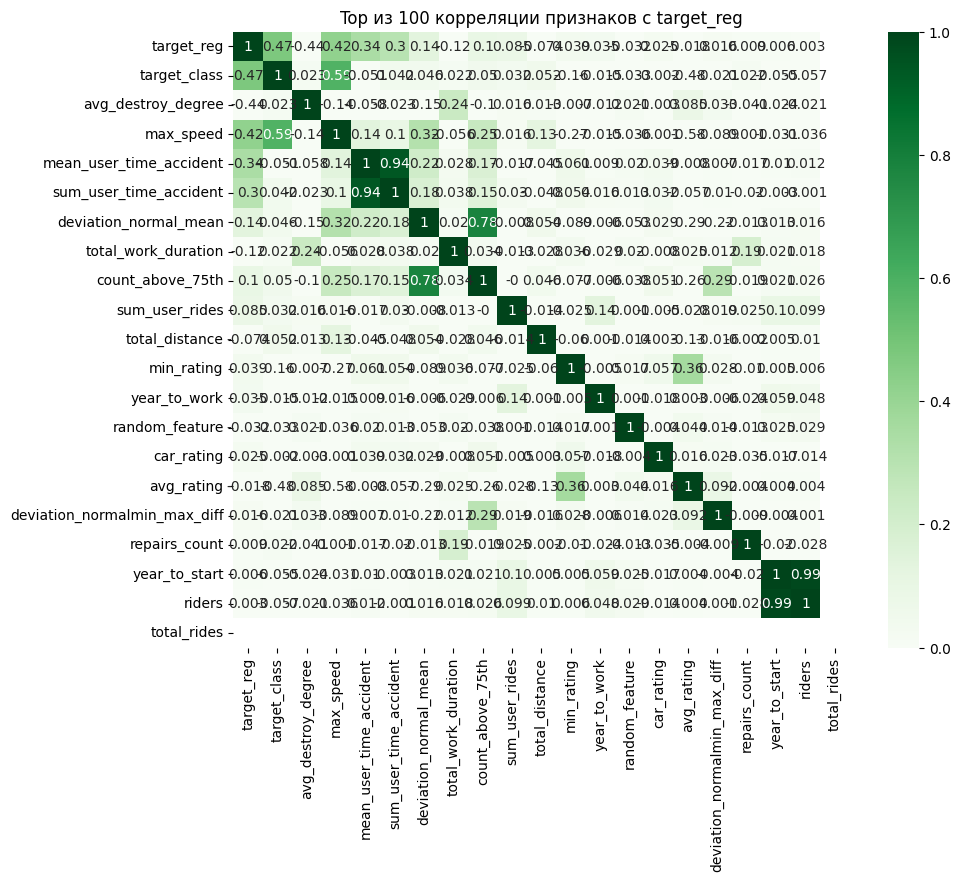

In [43]:
rarget_reg_pearson_corr_below_threshold = show_correlation_analysis(labeled_target_fitration_df, 'target_reg', 'random_feature', 100)

<ipython-input-42-6d93b9ce483e>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.dropna().corr().round(3)


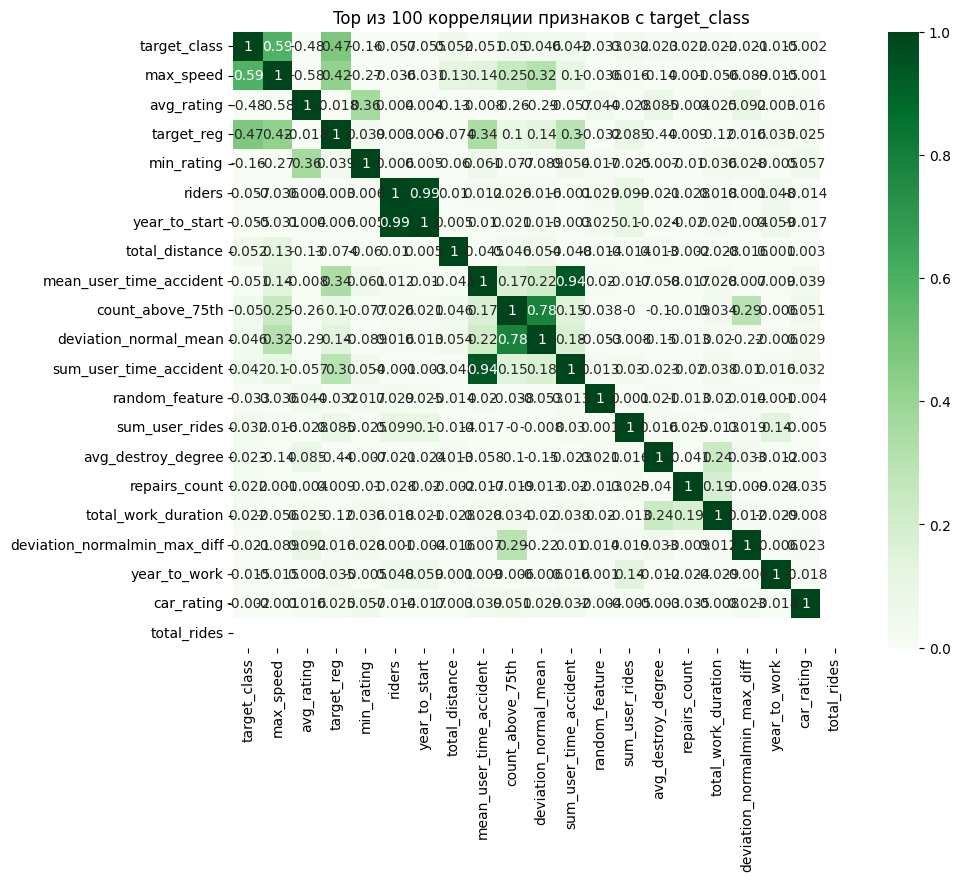

In [44]:
rarget_class_pearson_corr_below_threshold = show_correlation_analysis(labeled_target_fitration_df, 'target_class', 'random_feature', 100)

### Phik отбор

In [45]:
!pip install phik
import phik
from phik import report
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt

def show_correlation_by_phik_and_return_below_threshold(df, target_col_name, threshold_column, features_limit):
    phik_overview = df.phik_matrix().round(2)
    sorted_cols = phik_overview[target_col_name].abs().sort_values(ascending=False)
    top_features = sorted_cols.index[:features_limit + 1]
    filtered_phik_overview = phik_overview.loc[top_features, top_features]

    plot_correlation_matrix(filtered_phik_overview.values,
                            x_labels=filtered_phik_overview.columns,
                            y_labels=filtered_phik_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title="Phik Correlation",
                            fontsize_factor=1.2, figsize=(10, 7))
    plt.tight_layout()
    plt.show()

    threshold_index = sorted_cols.index.get_loc(threshold_column)
    features_below_threshold = sorted_cols.index[threshold_index:]
    correlations_below_threshold = sorted_cols.loc[features_below_threshold]
    return correlations_below_threshold.to_dict()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.8 MB/s eta 0:00:00


interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'total_rides', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'repairs_count', 'avg_destroy_degree', 'total_work_duration', 'random_feature']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable car_id is large: 2337. Are you sure this is not an interval variable? Analysis for pairs of variables including car_id can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_rides for analysis 1. Dropping this column
  warnings.warn(


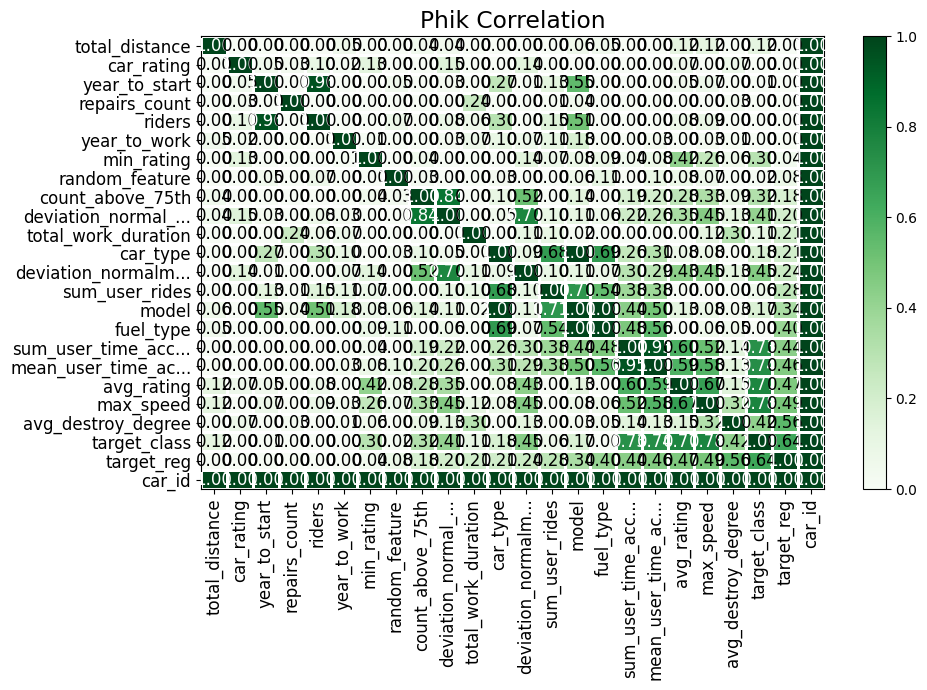

In [46]:
target_reg_phik_correlations_below_threshold = show_correlation_by_phik_and_return_below_threshold(labeled_target_fitration_df, 'target_reg', 'random_feature', 100)

In [47]:
target_reg_phik_correlations_below_threshold

{'random_feature': 0.08,
 'min_rating': 0.04,
 'year_to_work': 0.0,
 'riders': 0.0,
 'repairs_count': 0.0,
 'year_to_start': 0.0,
 'car_rating': 0.0,
 'total_distance': 0.0}

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'total_rides', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'repairs_count', 'avg_destroy_degree', 'total_work_duration', 'random_feature']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable car_id is large: 2337. Are you sure this is not an interval variable? Analysis for pairs of variables including car_id can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_rides for analysis 1. Dropping this column
  warnings.warn(


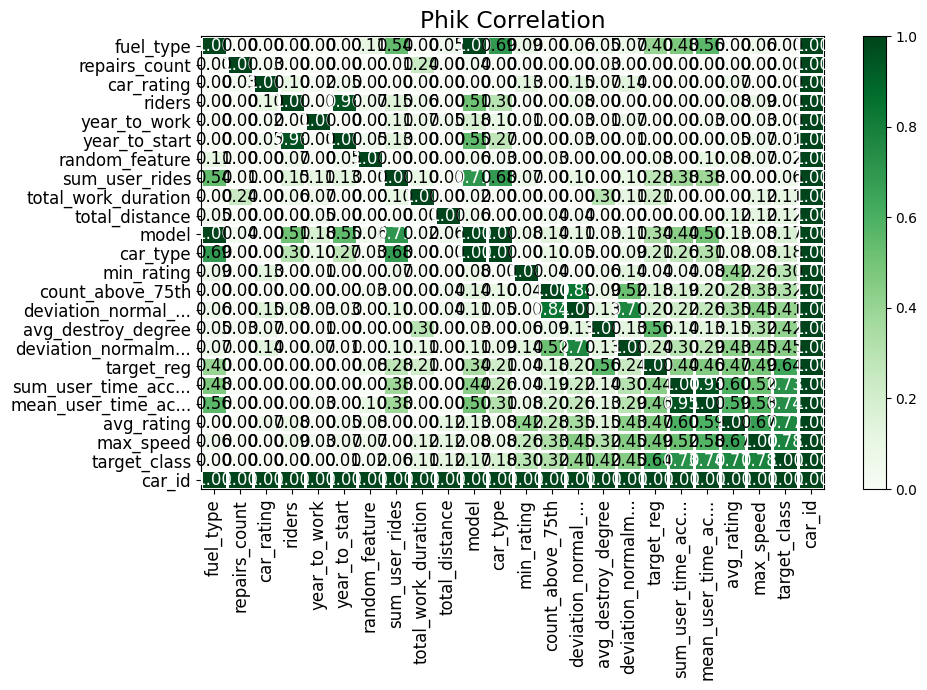

In [48]:
target_class_phik_correlations_below_threshold = show_correlation_by_phik_and_return_below_threshold(labeled_target_fitration_df, 'target_class', 'random_feature', 100)

In [49]:
target_class_phik_correlations_below_threshold

{'random_feature': 0.02,
 'year_to_start': 0.01,
 'year_to_work': 0.0,
 'riders': 0.0,
 'car_rating': 0.0,
 'repairs_count': 0.0,
 'fuel_type': 0.0}

### Shap отбор

In [50]:
!pip install shap
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_features(df):
    encoders = {}
    df_encoded = df.copy()

    for column in df.columns:
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df[column])
            encoders[column] = le

    return df_encoded, encoders

def train_xgb_model(df, target_column, task_type='classification', model_params=None, test_size=0.2, random_state=42, n_estimators=100):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    if model_params is None:
        default_objective = 'multi:softprob' if task_type == 'classification' else 'reg:squarederror'
        default_eval_metric = 'mlogloss' if task_type == 'classification' else 'rmse'
        model_params = {
            'max_depth': 3, 'eta': 0.1,
            'objective': default_objective,
            'eval_metric': default_eval_metric
        }
        if task_type == 'classification':
            model_params['num_class'] = len(y.unique())
    bst = xgb.train(model_params, dtrain, n_estimators, evals=[(dtest, 'test')], early_stopping_rounds=10)
    return bst

def print_structure(obj, level=0):
    prefix = "  " * level  # Indentation for readability

    if isinstance(obj, list):
        print(f"{prefix}List of length {len(obj)}")
        if len(obj) > 0:
            print_structure(obj[0], level + 1)
    elif hasattr(obj, 'shape'):
        print(f"{prefix}Array with shape: {obj.shape}")
    else:
        print(f"{prefix}Type: {type(obj)}")

def generate_shap_summary_xgb(model, df, target_column, features_limit=100, task_type='classification'):
    X = df.drop(columns=[target_column])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    if isinstance(shap_values, list):
        num_classes = len(shap_values)
    else:
        num_classes = shap_values.shape[-1]

    if task_type=='classification':
        for i in range(num_classes):
            class_shap_values = shap_values[i] if isinstance(shap_values, list) else shap_values[:, :, i]
            plt.figure()
            shap.summary_plot(class_shap_values, X, max_display=features_limit, show=False)
            plt.title(f"SHAP Summary график для класса {label_to_bug_dict[i]}")  # Adjust to use actual class names if you have them
            plt.show()
    else:
        shap.summary_plot(shap_values, X, max_display=features_limit)

    return shap_values

def get_shap_results(df_encoded, target_column, random_feature, task_type='classification', model_params=None, test_size=0.2, random_state=42, n_estimators=100, features_limit=25):
    bst_model = train_xgb_model(df_encoded, target_column, task_type, model_params, test_size, random_state, n_estimators)
    shap_values = generate_shap_summary_xgb(bst_model, df_encoded, target_column, features_limit, task_type)

    if task_type=='classification' and isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # классификация
        mean_abs_shap_values = np.abs(shap_values).mean(axis=(0, 2))
    else:
        # регрессия
        mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap_values, index=df_encoded.drop(columns=[target_column]).columns)

    random_feature_value = mean_abs_shap_series[random_feature]

    filtered_shap_series = mean_abs_shap_series[mean_abs_shap_series <= random_feature_value].sort_values(ascending=False)

    return bst_model, filtered_shap_series

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.0 MB/s eta 0:00:00


In [51]:
labeled_target_fitration_df, encoders = encode_categorical_features(labeled_target_fitration_df)

In [52]:
labeled_target_fitration_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

[0]	test-mlogloss:1.84397
[1]	test-mlogloss:1.59478
[2]	test-mlogloss:1.41007
[3]	test-mlogloss:1.25898
[4]	test-mlogloss:1.13324
[5]	test-mlogloss:1.02648
[6]	test-mlogloss:0.93563
[7]	test-mlogloss:0.85485
[8]	test-mlogloss:0.78293
[9]	test-mlogloss:0.72249
[10]	test-mlogloss:0.66540
[11]	test-mlogloss:0.61411
[12]	test-mlogloss:0.57030
[13]	test-mlogloss:0.52863
[14]	test-mlogloss:0.49255
[15]	test-mlogloss:0.45812
[16]	test-mlogloss:0.42803
[17]	test-mlogloss:0.39992
[18]	test-mlogloss:0.37439
[19]	test-mlogloss:0.35048
[20]	test-mlogloss:0.32887
[21]	test-mlogloss:0.30897
[22]	test-mlogloss:0.29235
[23]	test-mlogloss:0.27537
[24]	test-mlogloss:0.26053
[25]	test-mlogloss:0.24644
[26]	test-mlogloss:0.23367
[27]	test-mlogloss:0.22139
[28]	test-mlogloss:0.20993
[29]	test-mlogloss:0.19921
[30]	test-mlogloss:0.18950
[31]	test-mlogloss:0.18114
[32]	test-mlogloss:0.17332
[33]	test-mlogloss:0.16615
[34]	test-mlogloss:0.15937
[35]	test-mlogloss:0.15349
[36]	test-mlogloss:0.14793
[37]	test-m

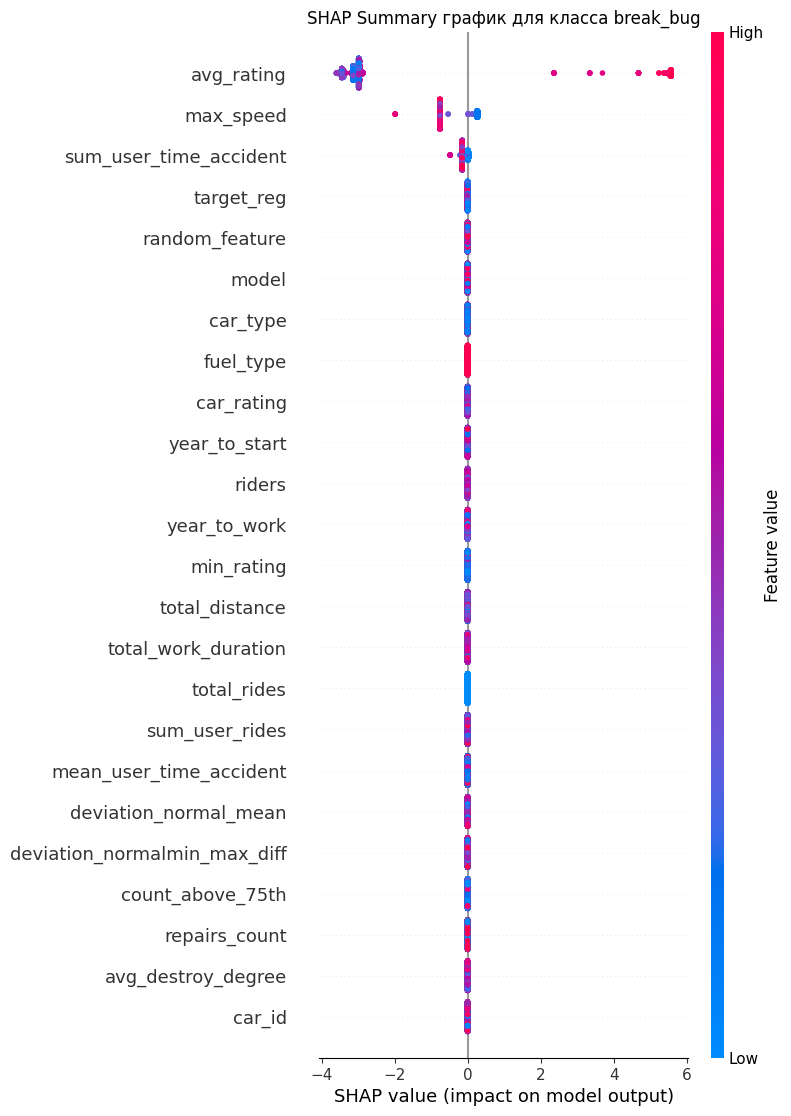

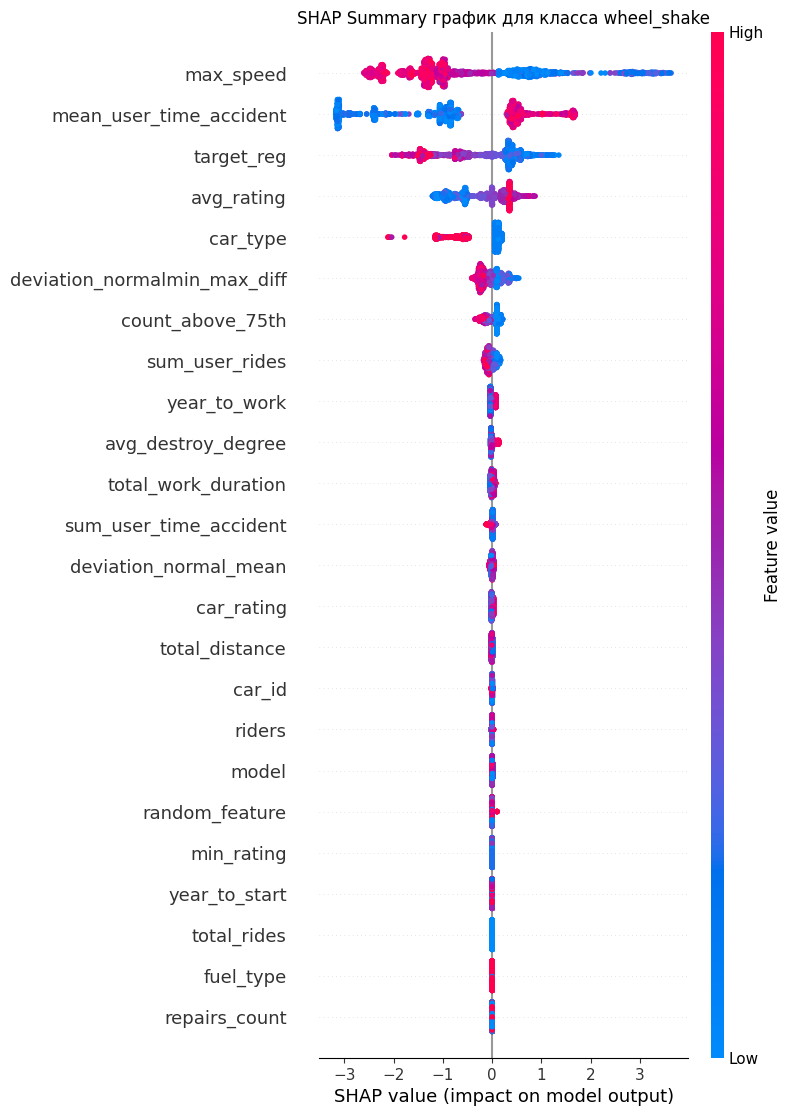

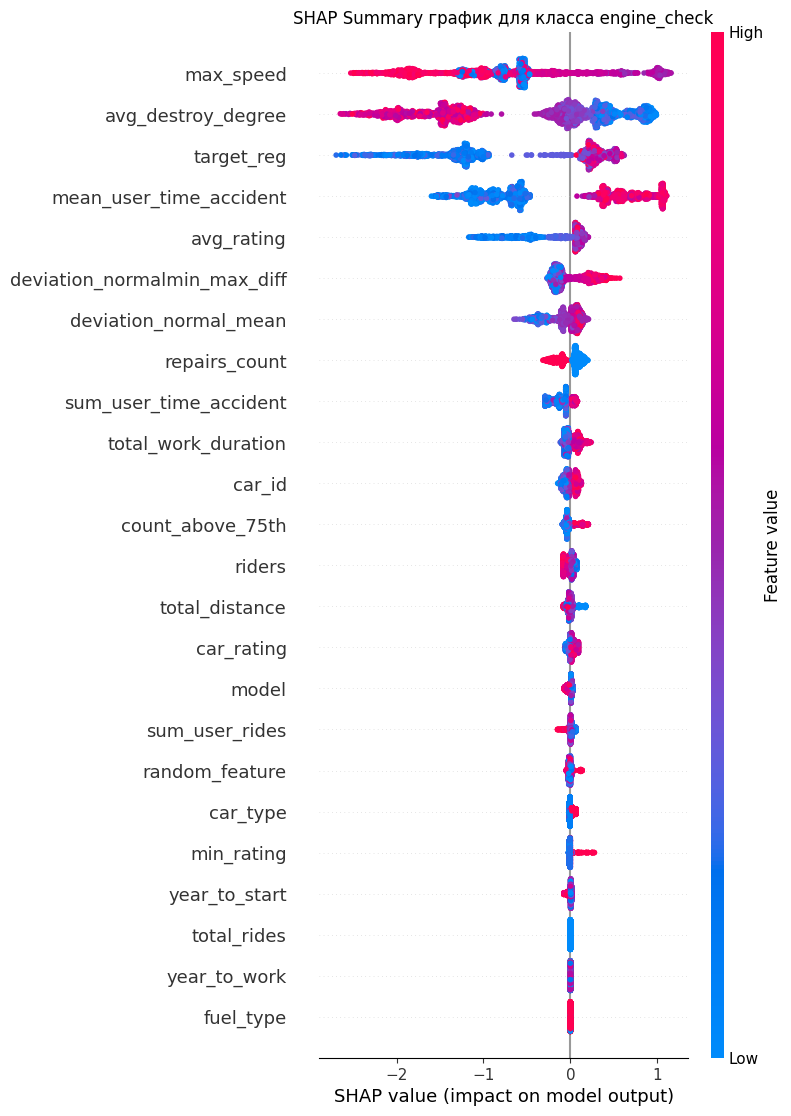

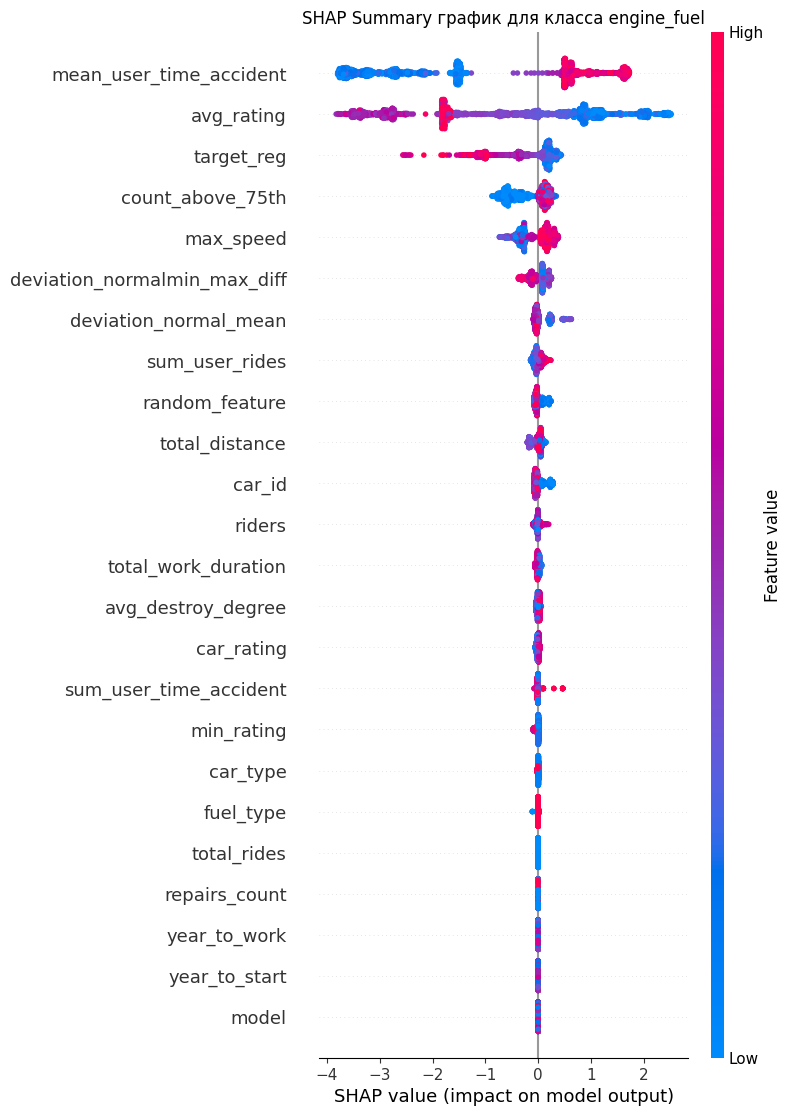

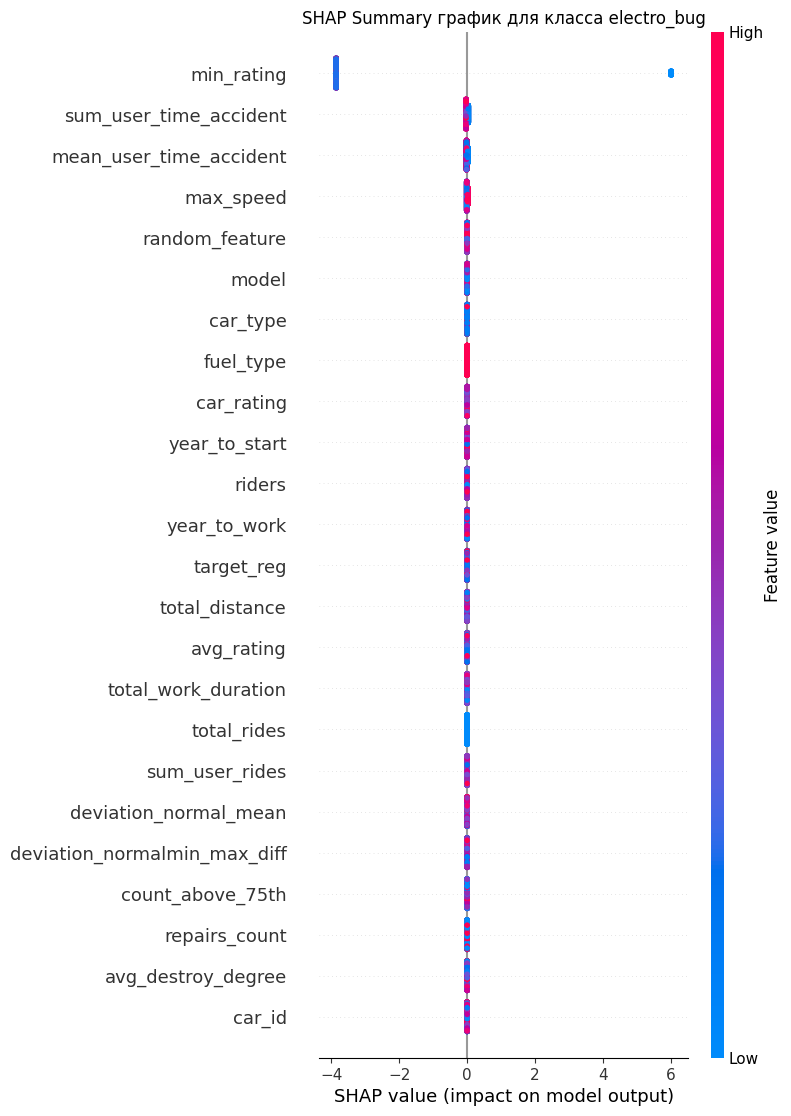

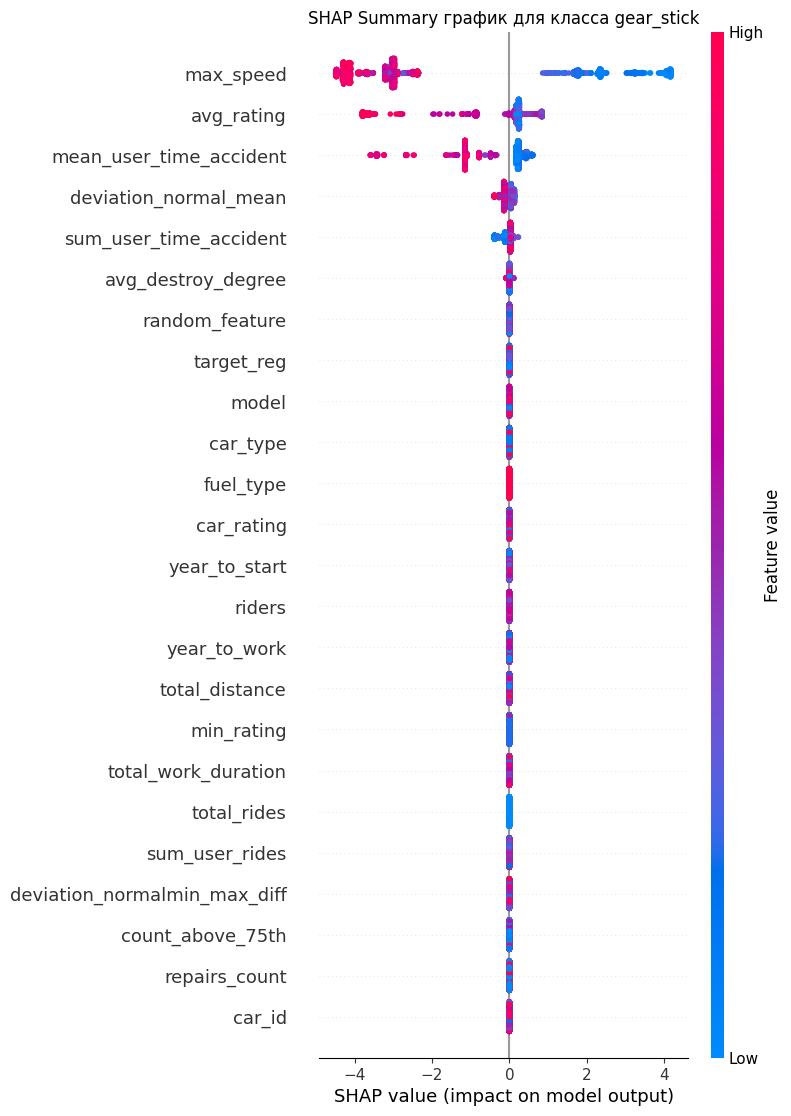

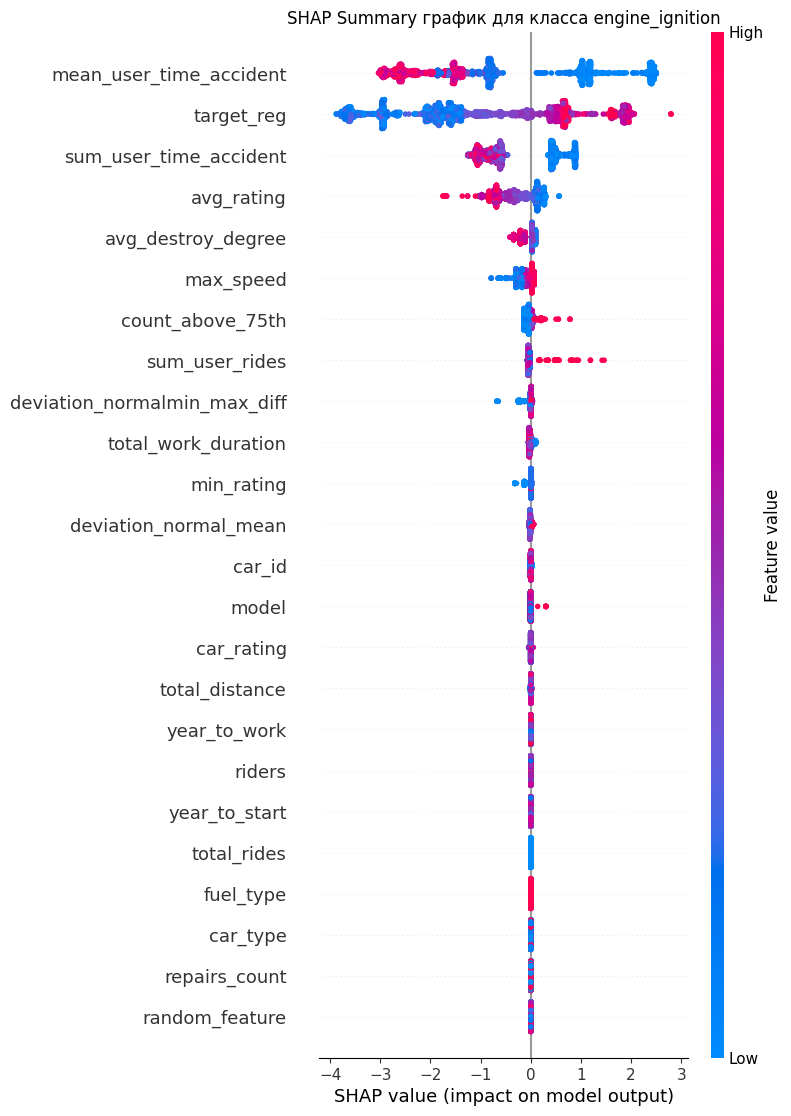

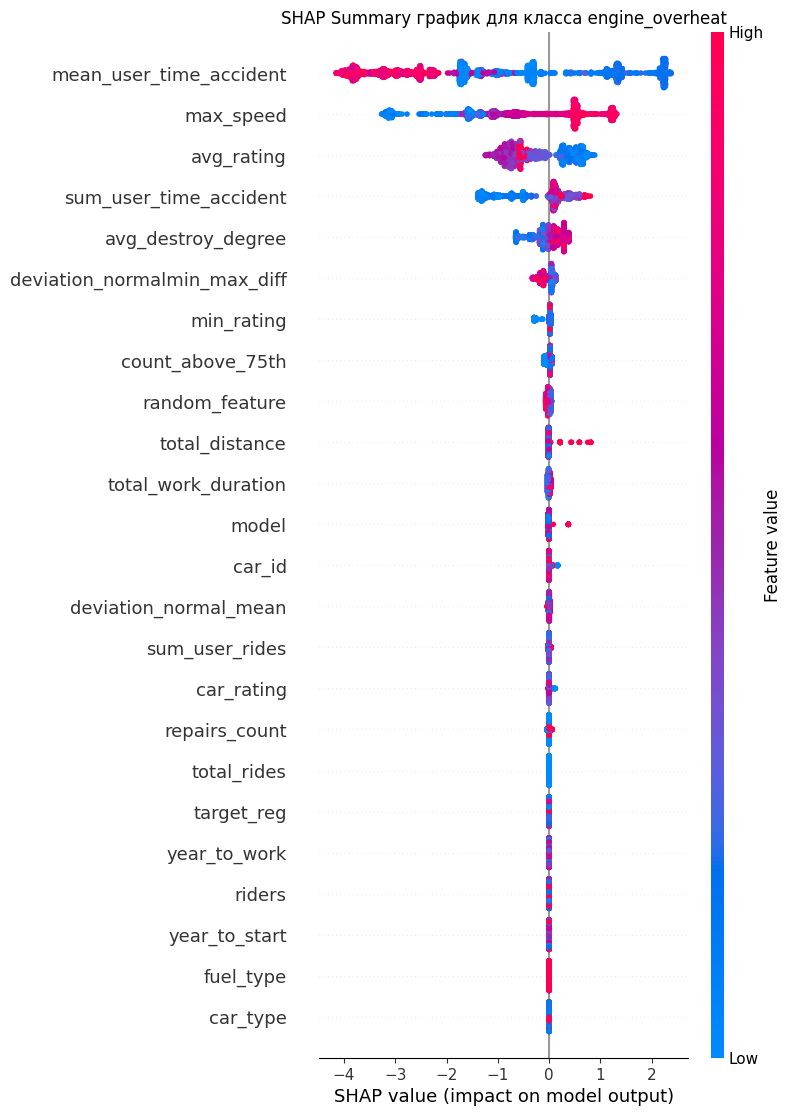

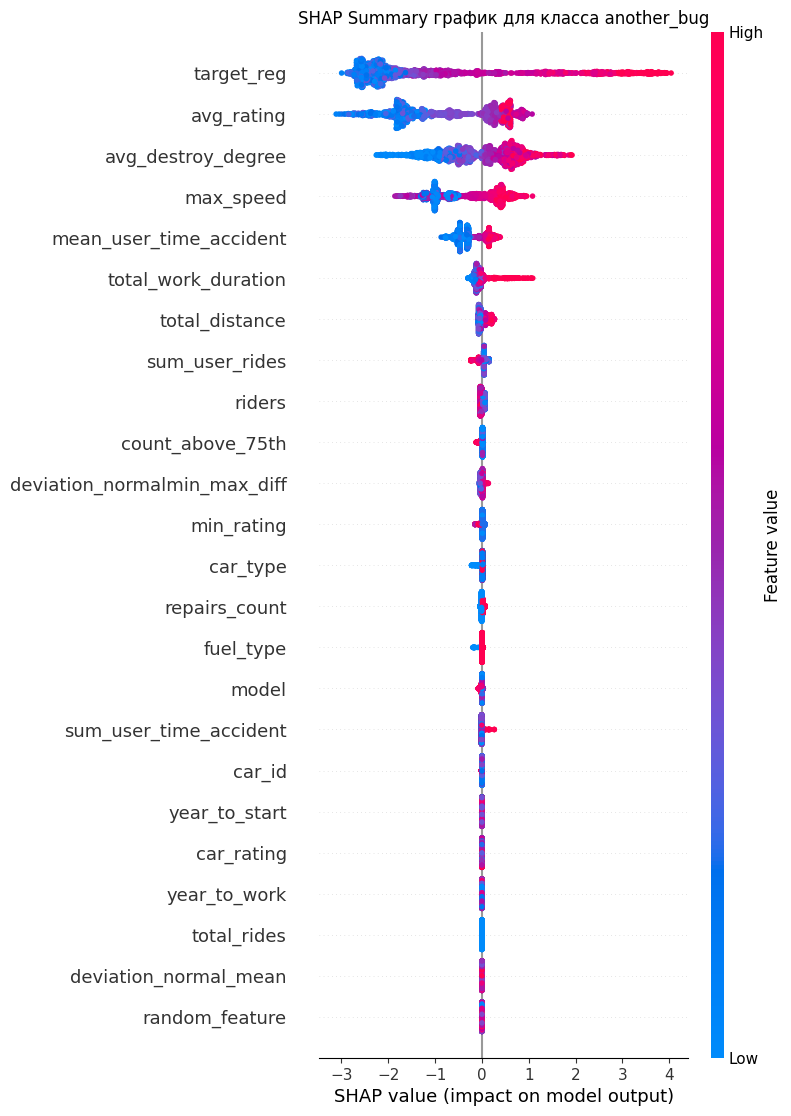

In [53]:
target_class_shap_results, target_class_mean_abs_shap_series = get_shap_results(labeled_target_fitration_df, 'target_class', 'random_feature')

In [54]:
target_class_mean_abs_shap_series

random_feature    0.010445
riders            0.009568
car_rating        0.005710
model             0.004787
year_to_work      0.003947
fuel_type         0.001088
year_to_start     0.000967
total_rides       0.000000
dtype: float32

[0]	test-rmse:17.06604
[1]	test-rmse:16.03083
[2]	test-rmse:15.15292
[3]	test-rmse:14.37245
[4]	test-rmse:13.67882
[5]	test-rmse:13.01981
[6]	test-rmse:12.48980
[7]	test-rmse:11.98736
[8]	test-rmse:11.47488
[9]	test-rmse:10.98870
[10]	test-rmse:10.59042
[11]	test-rmse:10.22713
[12]	test-rmse:9.97172
[13]	test-rmse:9.72151
[14]	test-rmse:9.49320
[15]	test-rmse:9.32512
[16]	test-rmse:9.15957
[17]	test-rmse:9.00029
[18]	test-rmse:8.84564
[19]	test-rmse:8.74015
[20]	test-rmse:8.65955
[21]	test-rmse:8.57671
[22]	test-rmse:8.45514
[23]	test-rmse:8.38008
[24]	test-rmse:8.27706
[25]	test-rmse:8.18797
[26]	test-rmse:8.13396
[27]	test-rmse:8.08604
[28]	test-rmse:8.05029
[29]	test-rmse:8.00226
[30]	test-rmse:7.95536
[31]	test-rmse:7.92379
[32]	test-rmse:7.87515
[33]	test-rmse:7.81644
[34]	test-rmse:7.79613
[35]	test-rmse:7.76728
[36]	test-rmse:7.74324
[37]	test-rmse:7.73258
[38]	test-rmse:7.70964
[39]	test-rmse:7.68511
[40]	test-rmse:7.66793
[41]	test-rmse:7.63885
[42]	test-rmse:7.62741
[43]	test

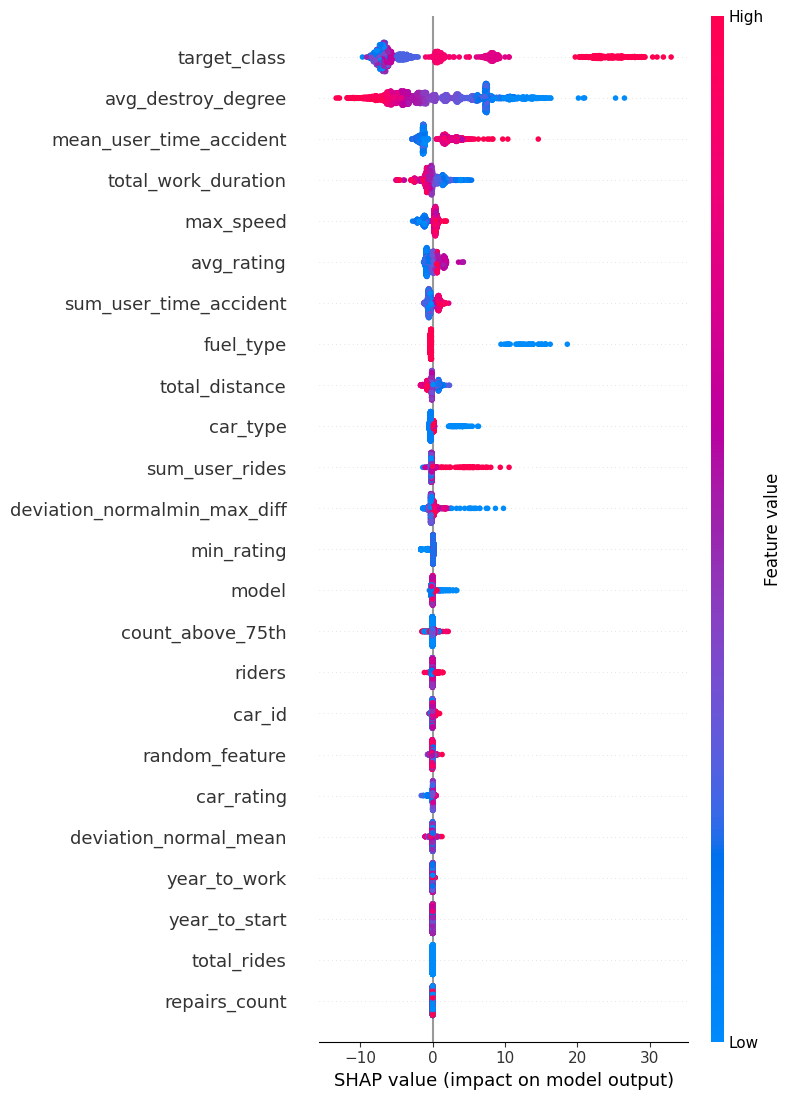

In [55]:
target_reg_shap_results, target_reg_mean_abs_shap_series = get_shap_results(labeled_target_fitration_df, 'target_reg', 'random_feature', 'regr')

In [56]:
target_class_mean_abs_shap_series

random_feature    0.010445
riders            0.009568
car_rating        0.005710
model             0.004787
year_to_work      0.003947
fuel_type         0.001088
year_to_start     0.000967
total_rides       0.000000
dtype: float32

### Отбор признаков, которые не попали хотя бы в одно из пересечений наборов для удаления на основе 2х методов

In [57]:
def intersection_of_dicts(pearson_corr_dict, phik_dict, shap_dict):
    print("Pearson корреляция словарь:", pearson_corr_dict)
    print("Phik словарь:", phik_dict)
    print("SHAP словарь:", shap_dict)

    all_three_intersection = set(pearson_corr_dict) & set(phik_dict) & set(shap_dict)
    print("Пересечения 3х:", all_three_intersection)

    pearson_phik_intersection = set(pearson_corr_dict) & set(phik_dict)
    print("Pearson и Phi_k пересечения:", pearson_phik_intersection)

    pearson_shap_intersection = set(pearson_corr_dict) & set(shap_dict)
    print("Pearson и SHAP пересечения:", pearson_shap_intersection)

    phik_shap_intersection = set(phik_dict) & set(shap_dict)
    print("Phi_k и SHAP пересечения:", phik_shap_intersection)

    return all_three_intersection, pearson_phik_intersection, pearson_shap_intersection, phik_shap_intersection

In [58]:
target_reg_all_three_intersection, target_reg_pearson_phik_intersection, target_reg_pearson_shap_intersection, target_reg_phik_shap_intersection = intersection_of_dicts(rarget_reg_pearson_corr_below_threshold, target_reg_phik_correlations_below_threshold, target_reg_mean_abs_shap_series.to_dict())

Pearson корреляция словарь: {'random_feature': 0.032, 'car_rating': 0.025, 'avg_rating': 0.018, 'deviation_normalmin_max_diff': 0.016, 'repairs_count': 0.009, 'year_to_start': 0.006, 'riders': 0.003, 'total_rides': nan}
Phik словарь: {'random_feature': 0.08, 'min_rating': 0.04, 'year_to_work': 0.0, 'riders': 0.0, 'repairs_count': 0.0, 'year_to_start': 0.0, 'car_rating': 0.0, 'total_distance': 0.0}
SHAP словарь: {'random_feature': 0.07102467864751816, 'car_rating': 0.0709977000951767, 'deviation_normal_mean': 0.0588906928896904, 'year_to_work': 0.010346630588173866, 'year_to_start': 0.0, 'total_rides': 0.0, 'repairs_count': 0.0}
Пересечения 3х: {'repairs_count', 'car_rating', 'random_feature', 'year_to_start'}
Pearson и Phi_k пересечения: {'riders', 'repairs_count', 'car_rating', 'year_to_start', 'random_feature'}
Pearson и SHAP пересечения: {'total_rides', 'repairs_count', 'car_rating', 'year_to_start', 'random_feature'}
Phi_k и SHAP пересечения: {'repairs_count', 'car_rating', 'year_t

In [59]:
target_reg_intersections_union = target_reg_all_three_intersection | target_reg_pearson_phik_intersection | target_reg_pearson_shap_intersection | target_reg_phik_shap_intersection

In [60]:
target_class_all_three_intersection, target_class_pearson_phik_intersection, target_class_pearson_shap_intersection, target_class_phik_shap_intersection = intersection_of_dicts(rarget_class_pearson_corr_below_threshold, target_class_phik_correlations_below_threshold, target_class_mean_abs_shap_series.to_dict())

Pearson корреляция словарь: {'random_feature': 0.033, 'sum_user_rides': 0.032, 'avg_destroy_degree': 0.023, 'repairs_count': 0.022, 'total_work_duration': 0.022, 'deviation_normalmin_max_diff': 0.021, 'year_to_work': 0.015, 'car_rating': 0.002, 'total_rides': nan}
Phik словарь: {'random_feature': 0.02, 'year_to_start': 0.01, 'year_to_work': 0.0, 'riders': 0.0, 'car_rating': 0.0, 'repairs_count': 0.0, 'fuel_type': 0.0}
SHAP словарь: {'random_feature': 0.010444572195410728, 'riders': 0.00956794060766697, 'car_rating': 0.00570972915738821, 'model': 0.004786749370396137, 'year_to_work': 0.0039466507732868195, 'fuel_type': 0.0010882404167205095, 'year_to_start': 0.0009674053872004151, 'total_rides': 0.0}
Пересечения 3х: {'car_rating', 'random_feature', 'year_to_work'}
Pearson и Phi_k пересечения: {'repairs_count', 'car_rating', 'random_feature', 'year_to_work'}
Pearson и SHAP пересечения: {'total_rides', 'car_rating', 'random_feature', 'year_to_work'}
Phi_k и SHAP пересечения: {'fuel_type',

In [61]:
target_class_intersections_union = target_class_all_three_intersection | target_class_pearson_phik_intersection | target_class_pearson_shap_intersection | target_class_phik_shap_intersection

In [62]:
target_class_selected_features_df = labeled_target_fitration_df[[col for col in labeled_target_fitration_df.columns if col not in target_class_intersections_union]]

In [63]:
check_data_distribution(labeled_target_fitration_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

In [64]:
check_data_distribution(target_class_selected_features_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   target_reg                    2337 non-null   float64
 4   target_class                  2337 non-null   int64  
 5   min_rating                    2337 non-null   float64
 6   avg_rating                    2337 non-null   float64
 7   total_distance                2337 non-null   float64
 8   max_speed                     2337 non-null   float64
 9   sum_user_rides                2337 non-null   int64  
 10  sum_user_time_accident        2337 non-null   float64
 11  mean_user_time_accident       2337 non-null   float64
 12  deviation_normal_mean         2337 non-null   float64
 13  dev

In [65]:
target_reg_selected_features_df = labeled_target_fitration_df[[col for col in labeled_target_fitration_df.columns if col not in target_reg_intersections_union]]

In [66]:
check_data_distribution(target_reg_selected_features_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   target_reg                    2337 non-null   float64
 5   target_class                  2337 non-null   int64  
 6   min_rating                    2337 non-null   float64
 7   avg_rating                    2337 non-null   float64
 8   total_distance                2337 non-null   float64
 9   max_speed                     2337 non-null   float64
 10  sum_user_rides                2337 non-null   int64  
 11  sum_user_time_accident        2337 non-null   float64
 12  mean_user_time_accident       2337 non-null   float64
 13  dev

In [67]:
train_xgb_model(target_class_selected_features_df, 'target_class', task_type='classification')

[0]	test-mlogloss:1.84399
[1]	test-mlogloss:1.59480
[2]	test-mlogloss:1.41009
[3]	test-mlogloss:1.25900
[4]	test-mlogloss:1.13325
[5]	test-mlogloss:1.02653
[6]	test-mlogloss:0.93562
[7]	test-mlogloss:0.85485
[8]	test-mlogloss:0.78291
[9]	test-mlogloss:0.72249
[10]	test-mlogloss:0.66547
[11]	test-mlogloss:0.61423
[12]	test-mlogloss:0.57041
[13]	test-mlogloss:0.52863
[14]	test-mlogloss:0.49247
[15]	test-mlogloss:0.45811
[16]	test-mlogloss:0.42805
[17]	test-mlogloss:0.40003
[18]	test-mlogloss:0.37430
[19]	test-mlogloss:0.35036
[20]	test-mlogloss:0.32860
[21]	test-mlogloss:0.30905
[22]	test-mlogloss:0.29272
[23]	test-mlogloss:0.27613
[24]	test-mlogloss:0.26102
[25]	test-mlogloss:0.24729
[26]	test-mlogloss:0.23394
[27]	test-mlogloss:0.22093
[28]	test-mlogloss:0.20989
[29]	test-mlogloss:0.19911
[30]	test-mlogloss:0.18933
[31]	test-mlogloss:0.18095
[32]	test-mlogloss:0.17317
[33]	test-mlogloss:0.16601
[34]	test-mlogloss:0.15957
[35]	test-mlogloss:0.15378
[36]	test-mlogloss:0.14796
[37]	test-m

In [68]:
train_xgb_model(target_reg_selected_features_df, 'target_reg', task_type='reg')

[0]	test-rmse:17.06604
[1]	test-rmse:16.03083
[2]	test-rmse:15.15292
[3]	test-rmse:14.37245
[4]	test-rmse:13.67882
[5]	test-rmse:13.01981
[6]	test-rmse:12.48980
[7]	test-rmse:11.98736
[8]	test-rmse:11.47488
[9]	test-rmse:10.98870
[10]	test-rmse:10.59042
[11]	test-rmse:10.22713
[12]	test-rmse:9.97172
[13]	test-rmse:9.72151
[14]	test-rmse:9.49320
[15]	test-rmse:9.32512
[16]	test-rmse:9.15957
[17]	test-rmse:9.00029
[18]	test-rmse:8.84564
[19]	test-rmse:8.74015
[20]	test-rmse:8.65955
[21]	test-rmse:8.57671
[22]	test-rmse:8.45514
[23]	test-rmse:8.38413
[24]	test-rmse:8.28067
[25]	test-rmse:8.18722
[26]	test-rmse:8.13273
[27]	test-rmse:8.08590
[28]	test-rmse:8.04966
[29]	test-rmse:8.00191
[30]	test-rmse:7.95581
[31]	test-rmse:7.89331
[32]	test-rmse:7.85959
[33]	test-rmse:7.84714
[34]	test-rmse:7.80624
[35]	test-rmse:7.77291
[36]	test-rmse:7.74404
[37]	test-rmse:7.72912
[38]	test-rmse:7.70279
[39]	test-rmse:7.69904
[40]	test-rmse:7.66227
[41]	test-rmse:7.62404
[42]	test-rmse:7.61487
[43]	test

In [69]:
current_df = target_reg_selected_features_df

In [70]:
from google.colab import drive
drive.mount('/content/drive')

COMP_DS_DIR_PATH = '/content/drive/MyDrive/docs/keepForever/mipt/comp_ds/'
TR_FSELECT_DS_PATH = COMP_DS_DIR_PATH + 'tr_fselect_ds.parquet'
TC_FSELECT_DS_PATH = COMP_DS_DIR_PATH + 'tc_fselect_ds.parquet'

target_reg_selected_features_df.to_parquet(TR_FSELECT_DS_PATH, engine='pyarrow')
pd.read_parquet(TR_FSELECT_DS_PATH).info()

target_class_selected_features_df.to_parquet(TC_FSELECT_DS_PATH, engine='pyarrow')
pd.read_parquet(TC_FSELECT_DS_PATH).info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   target_reg                    2337 non-null   float64
 5   target_class                  2337 non-null   int64  
 6   min_rating                    2337 non-null   float64
 7   avg_rating                    2337 non-null   float64
 8   total_distance                2337 non-null   float64
 9   max_speed                     2337 non-null   float64
 10  sum_user_rides                2337 non-null   int64

In [ ]:
raise ValueError()

### Выводы  
Были созданы признаки, для группировки сначало были объединены данные пользователей и поездок, а затем результат объединялся с данными набора для тренировки, к которым позже были добавлены оставшиеся данные.
Данные очищены.
С помощью трех методов были отобраны лучшие признаки путем подмешивания случайного признака.
Далее были отобраны на удаление те признаки, которые одновременно были рекомендованы любыми двуми подходами, что несколько улучшило результат.
В дальнейшем можно упростить задачу и перебрать все подряд forward selection, ведь признаков мало, но это решение не расширяемо.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

# РЕШЕНИЕ: Домашнее задание 2 - все кроме выводов - обучение первой модели с визуализацией

In [ ]:
# !pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
from typing import Tuple, List
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt
import numpy as np


SEED = 42
TEST_SIZE = 0.2

def detect_categorical_features(df: pd.DataFrame, target_col: str) -> List[str]:
    categorical_features = []
    for column in df.columns:
        if df[column].dtype not in [np.float32, np.float64, np.int8, np.int32, np.int64] and column != target_col:
            categorical_features.append(column)
    return categorical_features

def perform_stratified_split(df: pd.DataFrame, target_col_name: str, task_type: str) -> Tuple:
    X = df.drop(columns=[target_col_name])
    y = df[target_col_name]

    if task_type == 'regression':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)
    return X_train, X_test, y_train, y_test

def train_and_evaluate_catboost(X_train, X_test, y_train, y_test, categorical_features: List[str], task_type: str):
    if task_type == 'classification':
        num_classes = len(np.unique(y_train))

        if num_classes > 2:
            model = CatBoostClassifier(random_seed=SEED, verbose=False, cat_features=categorical_features, loss_function='MultiClass')
        else:
            model = CatBoostClassifier(random_seed=SEED, verbose=False, cat_features=categorical_features)

        eval_metric = accuracy_score
    elif task_type == 'regression':
        model = CatBoostRegressor(random_seed=SEED, verbose=False, cat_features=categorical_features)
        eval_metric = mean_squared_error
    else:
        raise ValueError("Задача может быть либо 'classification' либо 'regression'")

    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    if task_type == 'classification':
          predictions = model.predict(X_test)
          prob_predictions = model.predict_proba(X_test)[:, 1]
          if num_classes > 2:
              prob_predictions = model.predict_proba(X_test)
              f1 = f1_score(y_test, predictions, average='weighted')
              roc_auc = "ROC AUC не применим"
          else:
              prob_predictions = model.predict_proba(X_test)[:, 1]
              f1 = f1_score(y_test, predictions)
              roc_auc = roc_auc_score(y_test, prob_predictions)

          accuracy = accuracy_score(y_test, predictions)
          print(f'Accuracy: {accuracy}')
          print(f'F1: {f1}')
          print(f'ROC AUC: {roc_auc}')
          print('Отчет классификации:')
          print(classification_report(y_test, predictions))
          print('Confusion Matrix:')
          cm = confusion_matrix(y_test, predictions)
          print(cm)
    elif task_type == 'regression':
          predictions = model.predict(X_test)
          mse = mean_squared_error(y_test, predictions)
          print(f'MSE: {mse}')
    else:
        raise ValueError('Ошибка параметра типа задачи')

    return model

def train_eval_method(df: pd.DataFrame, target_col: str, target_cols: List[str], features_to_drop: List[str], task_type: str, generate_shap_waterfall: bool, generate_fimp:bool = True):
    df.info()
    other_targets = [col for col in target_cols if col != target_col]
    df = df.drop(columns=other_targets + features_to_drop, errors='ignore')
    categorical_features = detect_categorical_features(df, target_col)
    numerical_features = [col for col in df.columns if col not in categorical_features and col != target_col]
    X_train, X_test, y_train, y_test = perform_stratified_split(df, target_col, task_type)
    X_train.info()
    model = train_and_evaluate_catboost(X_train, X_test, y_train, y_test, categorical_features, task_type)

    if generate_shap_waterfall:
        generate_shap_summary_and_waterfall(model, X_train, features_limit=10, task_type=task_type)

    if generate_fimp:
        plot_top_n_feature_importances(model)

    return model, categorical_features, numerical_features

def generate_shap_summary_and_waterfall(model, X, features_limit=10, task_type='classification'):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    if task_type == 'classification' and len(shap_values.shape) == 3:
        num_classes = shap_values.shape[2]
        for i in range(num_classes):
            plt.figure()
            shap.summary_plot(shap_values[:, :, i], X, max_display=features_limit, show=False)
            plt.title(f"SHAP Summary Plot for Class {i}")
            plt.show()
    else:
        shap.summary_plot(shap_values, X, max_display=features_limit)

    # выберем случайное наблюдение
    sample_index = np.random.randint(0, X.shape[0])
    if task_type == 'classification' and len(shap_values.shape) == 3:
        predictions = model.predict_proba(X.iloc[[sample_index]])
        sample_class = np.argmax(predictions, axis=1)[0]
        print(f'sample_class: {sample_class}')
        print(f'sample ros: {X.iloc[sample_index]}')
        # рассмотрим график для предсказанного класса, например
        shap_waterfall_values = shap_values[sample_index, :, sample_class]
        expected_value = explainer.expected_value[sample_class]
    else:
        shap_waterfall_values = shap_values[sample_index]
        expected_value = explainer.expected_value if isinstance(explainer.expected_value, float) else explainer.expected_value[0]

    plt.figure()
    shap.plots.waterfall(shap.Explanation(values=shap_waterfall_values,
                                          base_values=expected_value,
                                          data=X.iloc[sample_index].values,
                                          feature_names=X.columns.tolist()),
                         max_display=features_limit)
    plt.show()

    return shap_values

def plot_top_n_feature_importances(model, n=10):
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_

    fi_df = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances})

    fi_df = fi_df.sort_values('Важность', ascending=False).reset_index(drop=True)

    top_n_df = fi_df.head(n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_n_df['Признак'], top_n_df['Важность'], color='skyblue')
    plt.xlabel('Важность')
    plt.title(f'Лучшие {n} признаков по важности модели CatBoost')
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
check_data_distribution(target_class_selected_features_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   year_to_start                 2337 non-null   int64  
 5   riders                        2337 non-null   int64  
 6   target_reg                    2337 non-null   float64
 7   target_class                  2337 non-null   int64  
 8   min_rating                    2337 non-null   float64
 9   avg_rating                    2337 non-null   float64
 10  total_distance                2337 non-null   float64
 11  max_speed                     2337 non-null   float64
 12  sum_user_rides                2337 non-null   int64  
 13  sum

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   year_to_start                 2337 non-null   int64  
 5   riders                        2337 non-null   int64  
 6   target_reg                    2337 non-null   float64
 7   target_class                  2337 non-null   int64  
 8   min_rating                    2337 non-null   float64
 9   avg_rating                    2337 non-null   float64
 10  total_distance                2337 non-null   float64
 11  max_speed                     2337 non-null   float64
 12  sum_user_rides                2337 non-null   int64  
 13  sum

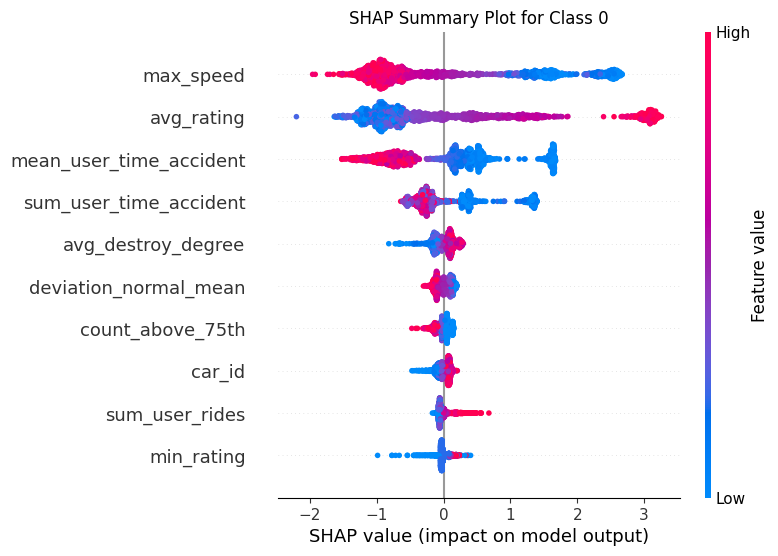

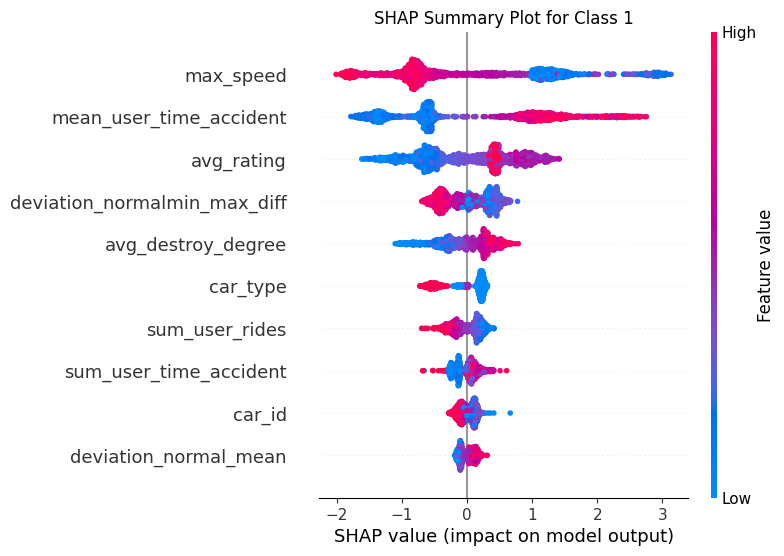

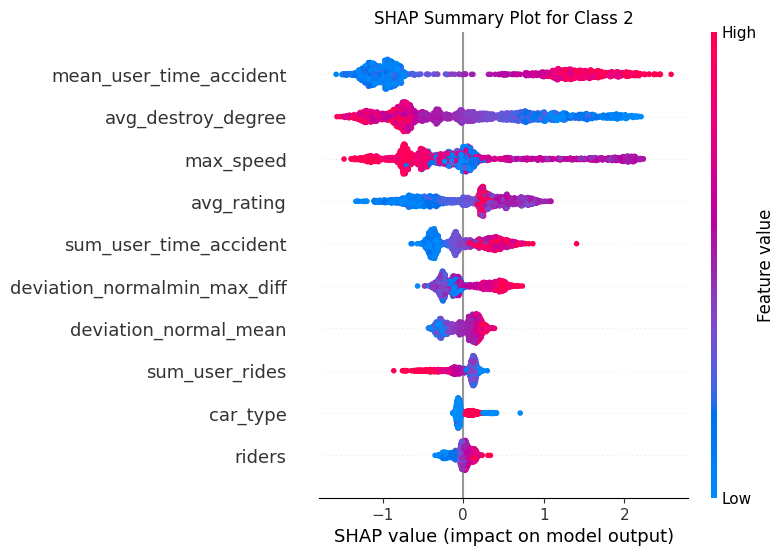

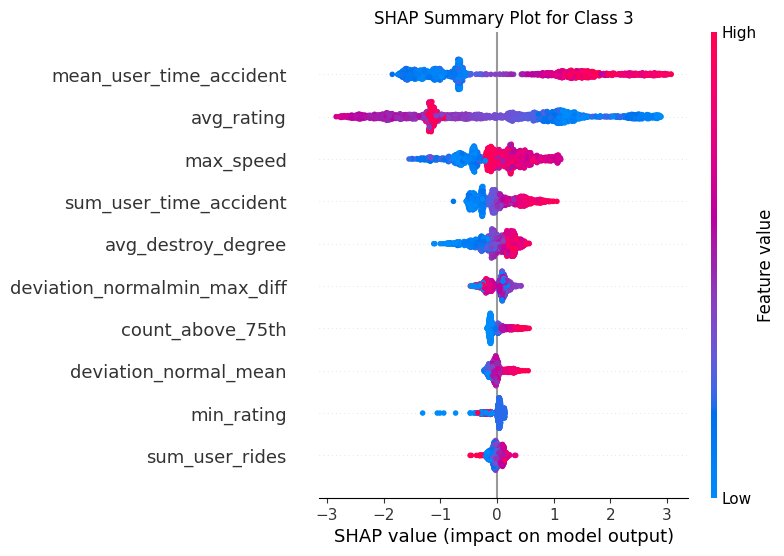

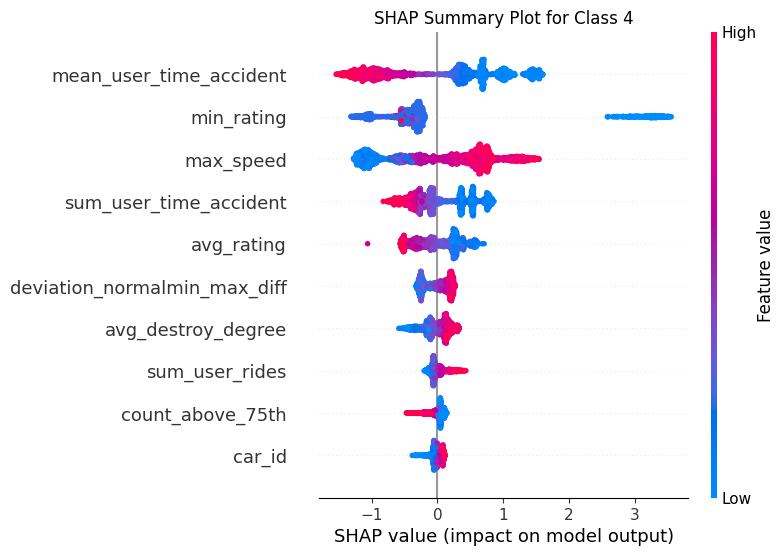

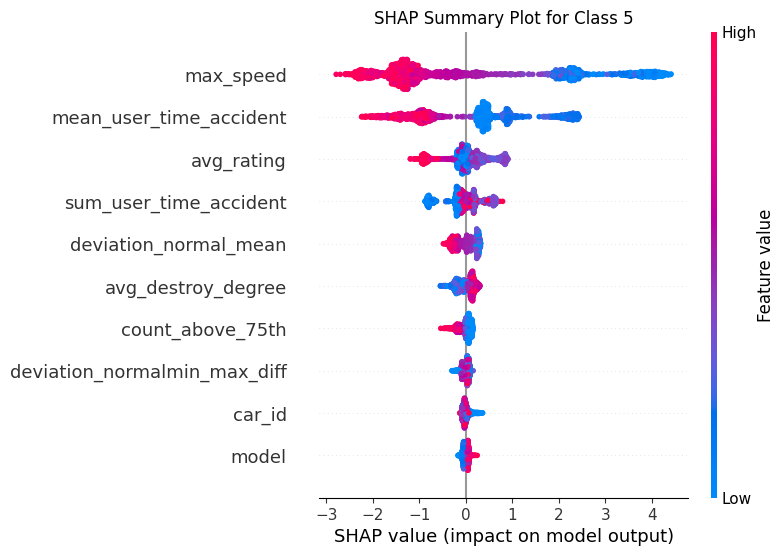

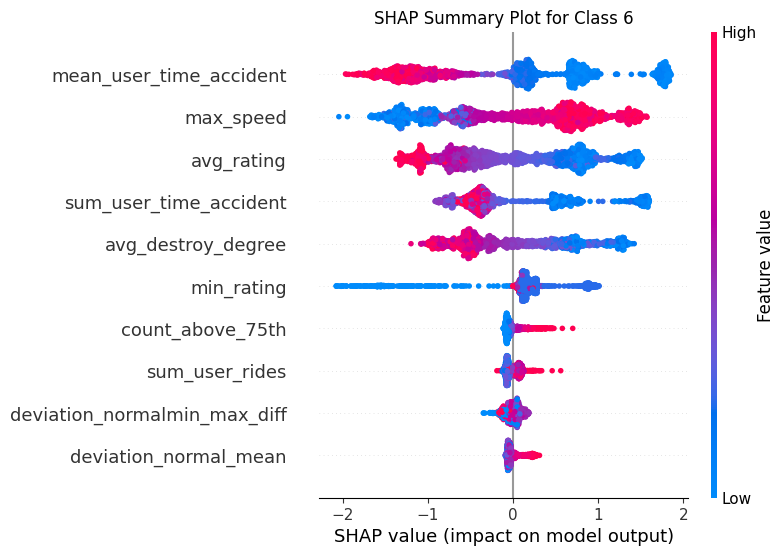

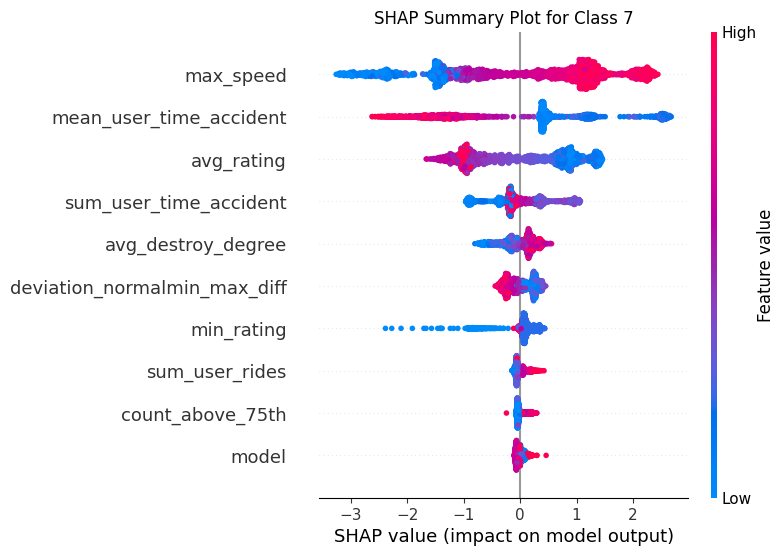

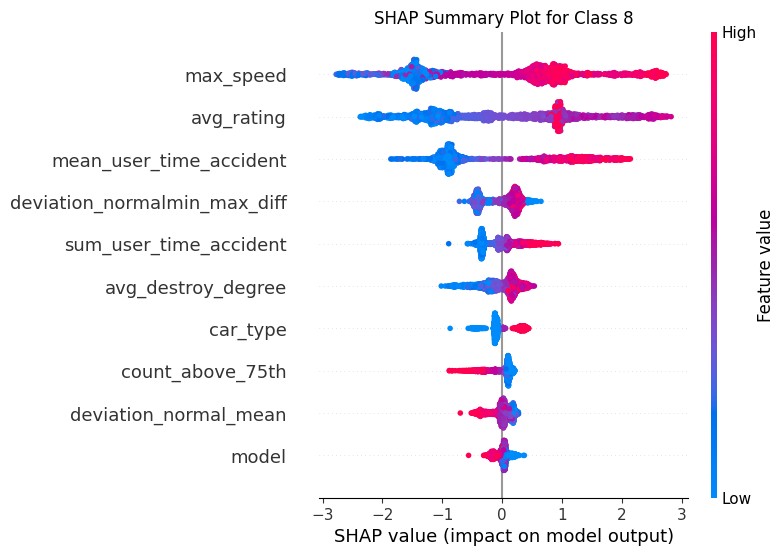

sample_class: 1
sample ros: car_id                          3.710000e+02
model                           2.300000e+01
car_type                        1.000000e+00
fuel_type                       1.000000e+00
year_to_start                   2.013000e+03
riders                          4.420400e+04
min_rating                      1.000000e-01
avg_rating                      4.579253e+00
total_distance                  1.347047e+07
max_speed                       1.294139e+02
sum_user_rides                  1.566620e+05
sum_user_time_accident          1.925000e+03
mean_user_time_accident         1.659483e+01
deviation_normal_mean           8.453069e+00
deviation_normalmin_max_diff    6.437500e+01
count_above_75th                9.900000e+01
avg_destroy_degree              3.277143e+00
Name: 249, dtype: float64


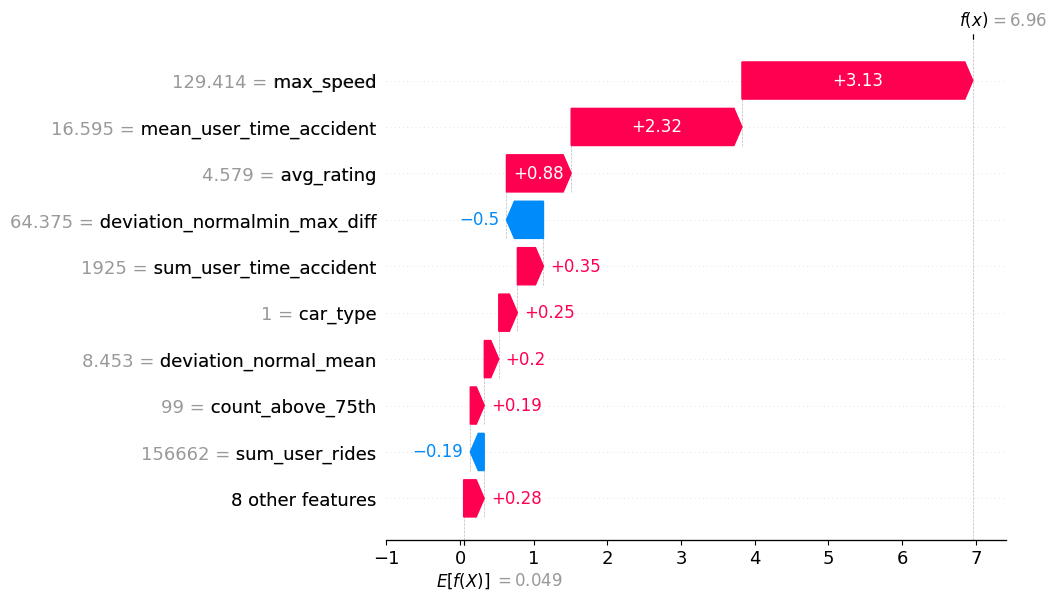

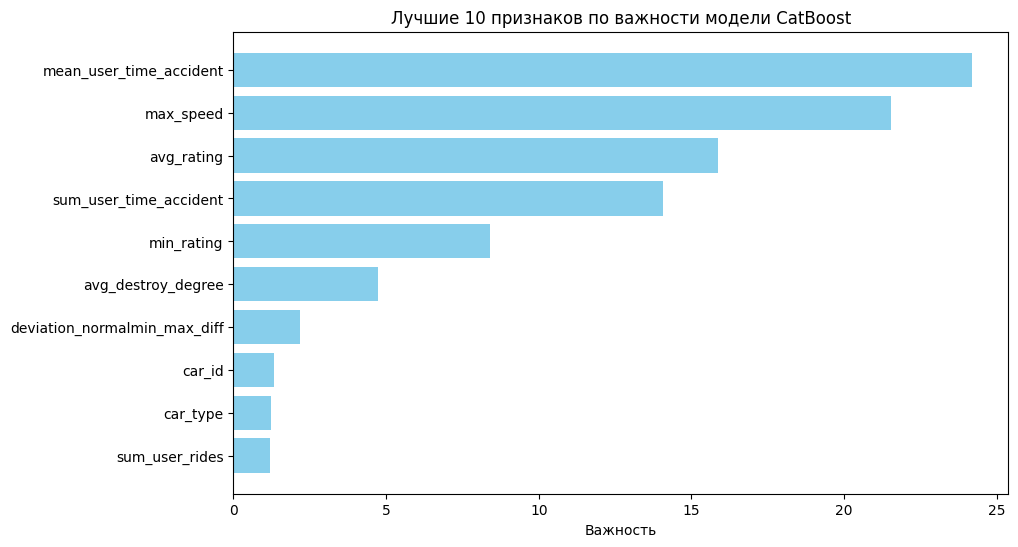

Категориальные признаки: 0 []
Числовые признаки: 17 ['car_id', 'model', 'car_type', 'fuel_type', 'year_to_start', 'riders', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'avg_destroy_degree']
Целевые переменные ['target_class', 'target_reg']


" Для удобства отобразим ниже метки\nbug_dict = {\n    'break_bug':   \t\t0,\n    'wheel_shake': \t\t1,\n    'engine_check':\t\t2,\n    'engine_fuel': \t\t3,\n    'electro_bug': \t\t4,\n    'gear_stick':  \t\t5,\n    'engine_ignition':  6,\n    'engine_overheat':  7,\n    'another_bug': \t\t8\n     }\n"

In [ ]:
features2drop = list(target_class_intersections_union) # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты

model_class, categorical_features, numerical_features = train_eval_method(target_class_selected_features_df, 'target_class', targets, features2drop, 'classification', True)

cat_features = categorical_features # категориальные признаки

num_features = numerical_features # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

''' Для удобства отобразим ниже метки
bug_dict = {
    'break_bug':   		0,
    'wheel_shake': 		1,
    'engine_check':		2,
    'engine_fuel': 		3,
    'electro_bug': 		4,
    'gear_stick':  		5,
    'engine_ignition':  6,
    'engine_overheat':  7,
    'another_bug': 		8
     }
'''

In [ ]:
check_data_distribution(target_reg_selected_features_df)
print(target_reg_selected_features_df['target_reg'].min())
print(target_reg_selected_features_df['target_reg'].max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

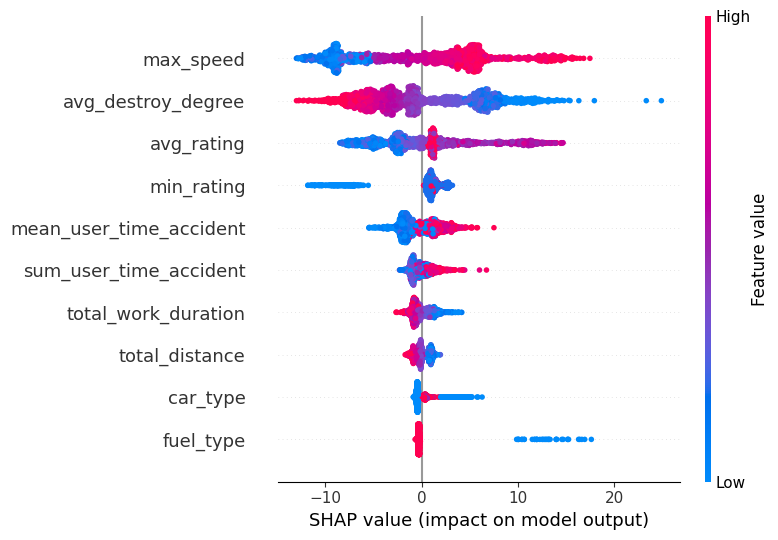

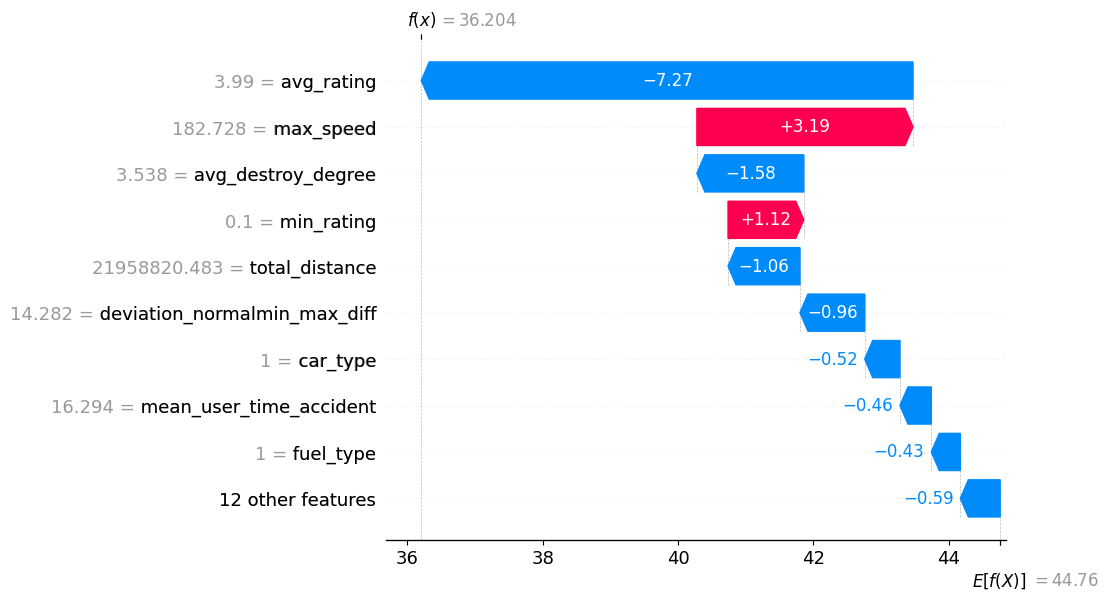

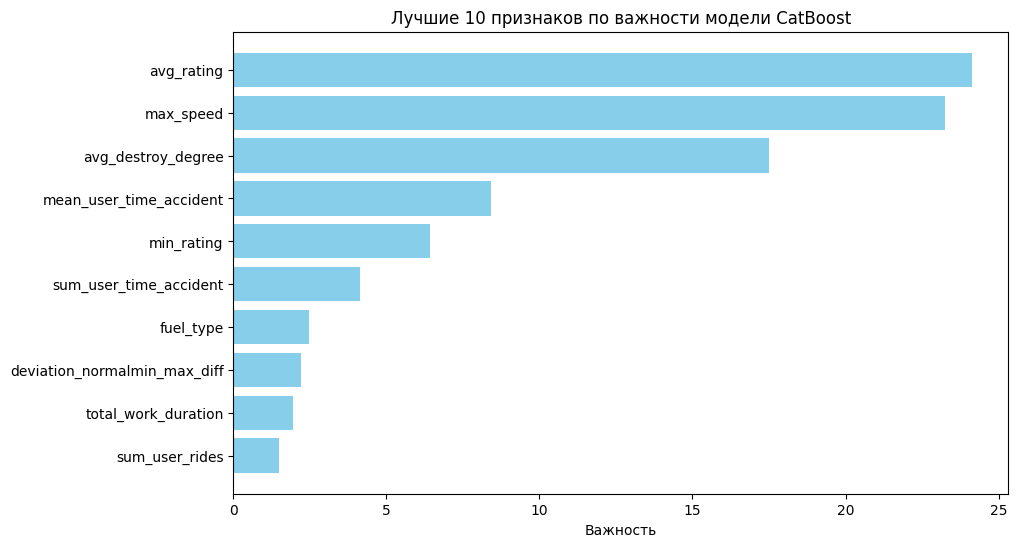

Категориальные признаки: 0 []
Числовые признаки: 21 ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'repairs_count', 'avg_destroy_degree', 'total_work_duration']
Целевые переменные ['target_class', 'target_reg']


In [ ]:
features2drop = list(target_reg_intersections_union) # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты

model_reg, categorical_features, numerical_features = train_eval_method(target_reg_selected_features_df, 'target_reg', targets, features2drop, 'regression', True)

cat_features = categorical_features # категориальные признаки

num_features = numerical_features # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# решения выполнено выше - все графики

# РЕШЕНИЕ: Домашнее задание 2 (продолжение) - Выводы
* были классифицированы признаки (категориальные, числовые, таргеты);  
* были выделены X и Y наборы;  
* были 2 способами сделаны рызделения данных на обучающую и валидационную выборки (с SEED);  
* были обучены модели мультиклассификации и регрессии;  
* были визуализированы важность признаков (для всех классов для классификации и для цели для регрессии) а также через feature importance встроенным методом в CatBoost;  
* в частности был построен waterfall_plot из библиотеки SHAP (ниже подробный анализ);  
* был построен classification_report и  confusion_matrix, метрика точности и f1.

Анализ SHAP графиков суммарных:
- низкая скорость вероятно следствие поломки (водитель снижает скорость), в этом смысле признак отчасти теряет ценность для именно предсказания (наиболее вероятно);
- с другой стороны, это может свидетельствовать о нервном (или аккуратном) вождении, водитель, который имеет очень высокий рейтинг судя по графику вероятно слонен часто тормозить (чувствует машину, не обязательно это аккуратное вождение, хотя среди гонщиков вероятно меньше любителей нажимать на тормоз, хотя заносы обычно снижают скорость и нужны лишь для эффекта, поэтому профессиональные гонщики-таксисты с перчатками на руках вероятно используют тормоза достаточно часто, но их число в общей массе должно быть невелико);
- чем чаще попадает пользователь (особенно) с высоким рейтингом в аварии, и чем более умеренная или низка я его скорость, тем более уверенно классифицируется тряска руля (то есть следствием поломки наиболее вероятно можно считать снижение скорости у водителей с высоким рейтингом при тряске руля);
- частое попадание в аварии может увеличивать вероятность неисправности панели приборов (и топливной системы) (как и высокая скорость);
- выгодно иметь водителей с высоким рейтингом, согласно модели эта дорогостоящая поломка (сравнима со стоимостью автомобиля) скорее бывает у водителей с низким рейтингом;
- гонщики-таксисты скорее будут по модели иметь проблемы с зажиганием, перегревом двигателя (и другими проблемами.

На waterfall графике для случайного примера видно то, что для машины с car_id 371 высокая скорость вносит больший вклад в предсказание проблемы с тряской руля.

В целом, результаты SHAP и feature importance схожи: одники из важнейших являются частота попадания пользователя в аварию, склонность к гонкам и средний рейтинг.

Чаще всего модель ошибается в предсказании класса 2 - (вместо проверки двигателя модель классифицирует наблюдения по ошибке как "прочие неисправности"). И наоборот, вместо верной классификации в "прочие неисправности" модель определяет наблюдения в "тряска руля", "проверка двигателя" и "проблемы с тобливной системой."

Возможно, больше данных об относительном (относительно всех наблюдений, например, стандартиз. откл. от средних и т.д.) и анализ лагов позволили бы выявить действительно факторы которые предшествуют аварии а не являются следствием.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

# РЕШЕНИЕ: Домашнее задание 3 (Выводы в этой ячейке, решение - ниже)
Выводы: как и ожидалось, в целом подбор гиперпараметров дает незначительный прирост (по сравнению с отбором признаков и подходов решения:
* до перебора - после перебора:  
  * регрессия - до перебора - после перебора 84.689415
  * классификация - до перебора - после перебора
* была реализована функциональность (для решения задач классификации и регрессии) целевой функции objective:
  * была создана логика для ранней остановки попытки (иногда отрабатывает, сравнивая результаты попытки с предыдущими аналогичными шагами запущенными ранее)
  * реализована кросс валидация;
  * поддержка обоих целевых функций;
  * созданые визуализации результатов поиска в пространстве гиперпараметров
* сделан запуск optuna;
* подобрыны гиперпараметры для CatBoostClassifier;
* обучены модели с новыми гиперпараметрами, сделаны выводы.


In [15]:
!pip install catboost
!pip install optuna

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import f1_score, mean_squared_error
from typing import List
import optuna
from optuna.pruners import MedianPruner

In [16]:
from google.colab import drive
drive.mount('/content/drive')

COMP_DS_DIR_PATH = '/content/drive/MyDrive/docs/keepForever/mipt/comp_ds/'
TR_FSELECT_DS_PATH = COMP_DS_DIR_PATH + 'tr_fselect_ds.parquet'
TC_FSELECT_DS_PATH = COMP_DS_DIR_PATH + 'tc_fselect_ds.parquet'

target_reg_selected_features_df = pd.read_parquet(TR_FSELECT_DS_PATH)
target_class_selected_features_df = pd.read_parquet(TC_FSELECT_DS_PATH)

SEED = 42
TEST_SIZE = 0.2
N_SPLITS = 3
N_TRIALS = 32
TARGET_REG = 'target_reg'
TARGET_CLASS = 'target_class'
REGRESSION_TASK = 'regression'
CLASSIFICATION_TASK = 'classification'
EARLY_STOPPING_ROUNDS = 10
!cpuinfo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python Version: 3.10.12.final.0 (64 bit)
Cpuinfo Version: 9.0.0
Vendor ID Raw: GenuineIntel
Hardware Raw: 
Brand Raw: Intel(R) Xeon(R) CPU @ 2.30GHz
Hz Advertised Friendly: 2.3000 GHz
Hz Actual Friendly: 2.3000 GHz
Hz Advertised: (2300000000, 0)
Hz Actual: (2299998000, 0)
Arch: X86_64
Bits: 64
Count: 40
Arch String Raw: x86_64
L1 Data Cache Size: 655360
L1 Instruction Cache Size: 655360
L2 Cache Size: 5242880
L2 Cache Line Size: 256
L2 Cache Associativity: 6
L3 Cache Size: 47185920
Stepping: 
Model: 63
Family: 6
Processor Type: 
Flags: abm, aes, apic, arat, arch_capabilities, avx, avx2, bmi1, bmi2, clflush, cmov, constant_tsc, cpuid, cx16, cx8, de, erms, f16c, fma, fpu, fsgsbase, fxsr, ht, hypervisor, ibpb, ibrs, invpcid, invpcid_single, lahf_lm, lm, mca, mce, md_clear, mmx, movbe, msr, mtrr, nonstop_tsc, nopl, nx, osxsave, pae, pat, pcid, pclmulqdq, pdpe1gb,

In [17]:
# работает при услувии что категорийные - не численные поля, иначе требуется передавать набор вручную
def detect_categorical_features(df: pd.DataFrame, target_col: str) -> List[str]:
    categorical_features = []
    for column in df.columns:
        if df[column].dtype not in [np.float32, np.float64, np.int8, np.int32, np.int64] and column != target_col:
            categorical_features.append(column)
    return categorical_features

def get_params_for_trial(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "depth": trial.suggest_int("depth", 3, 9),
        # "task_type": "GPU",
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
    }
    return params

def objective(trial, df: pd.DataFrame, target_col: str, target_cols: List[str], task_type: str):
    other_targets = [col for col in target_cols if col != target_col]
    df = df.drop(columns=other_targets, errors='ignore')
    categorical_features = detect_categorical_features(df, target_col)

    params_for_trial = get_params_for_trial(trial)
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    scores = []
    for step, (train_index, test_index) in enumerate(kf.split(df)):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
        y_train, y_test = train_df[target_col], test_df[target_col]

        model, focused_metric = train_and_evaluate_catboost(
            X_train, X_test, y_train, y_test, categorical_features, task_type, params_for_trial)

        scores.append(focused_metric)

        if (step + 1 ) % 2 == 0:
            trial.report(np.mean(scores[:(step +1)]), step)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    result = np.mean(scores)

    print(f"Trial {trial.number} завершен со значением {result} с параметрами {trial.params}.")
    return result


def train_and_evaluate_catboost(X_train, X_test, y_train, y_test, categorical_features, task_type, params_dict):
    if task_type == 'classification':
        model = CatBoostClassifier(random_seed=SEED, verbose=False, cat_features=categorical_features, early_stopping_rounds=EARLY_STOPPING_ROUNDS, **params_dict)
    elif task_type == 'regression':
        model = CatBoostRegressor(random_seed=SEED, verbose=False, cat_features=categorical_features, early_stopping_rounds=EARLY_STOPPING_ROUNDS, **params_dict)
    else:
        raise ValueError("Задача - либо 'classification' либо 'regression'.")

    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    if task_type == 'classification':
        predictions = model.predict(X_test)

        num_classes = len(np.unique(y_train))
        if num_classes > 2:
            f1 = f1_score(y_test, predictions, average='weighted')
        else:
            f1 = f1_score(y_test, predictions)
        focused_metric = f1
    elif task_type == 'regression':
        predictions = model.predict(X_test)
        focused_metric = mean_squared_error(y_test, predictions)

    return model, focused_metric


def run_optimization_process(df: pd.DataFrame, target_col: str, target_cols: List[str], task_type: str, n_trials: int = 128, direction: str = "maximize"):
    study = optuna.create_study(direction=direction, pruner=MedianPruner())
    study.optimize(lambda trial: objective(trial, df, target_col, target_cols, task_type), n_trials=n_trials)

    print(f"Лучшее выполнение:\n метрика - {study.best_trial.value}, параметры - {study.best_trial.params}")

    sort_direction_asc = True if direction == 'minimize' else False
    trials_df = study.trials_dataframe().sort_values("value", ascending=sort_direction_asc)

    display(optuna.visualization.plot_optimization_history(study))
    params = ['learning_rate', 'l2_leaf_reg', 'depth', 'bootstrap_type']
    display(optuna.visualization.plot_slice(study, params=params, target_name='f1_score'))
    display(optuna.visualization.plot_parallel_coordinate(study))
    display(optuna.visualization.plot_param_importances(study))

    return study, trials_df


def one_shot_train_eval(df: pd.DataFrame, target_col: str, target_cols: List[str], task_type: str, params_for_trial):
    other_targets = [col for col in target_cols if col != target_col]
    df = df.drop(columns=other_targets, errors='ignore')
    categorical_features = detect_categorical_features(df, target_col)

    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    scores = []
    for step, (train_index, test_index) in enumerate(kf.split(df)):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
        y_train, y_test = train_df[target_col], test_df[target_col]

        model, focused_metric = train_and_evaluate_catboost(
            X_train, X_test, y_train, y_test, categorical_features, task_type, params_for_trial)

        scores.append(focused_metric)

    result = np.mean(scores)

    print(f"Значение метрики - {result} для параметров {trial.params}.")
    return result

In [18]:
reg_study, reg_trials_df = run_optimization_process(target_reg_selected_features_df, TARGET_REG, [TARGET_REG, TARGET_CLASS], REGRESSION_TASK, n_trials=N_TRIALS, direction='minimize')

[I 2024-03-31 23:55:59,382] A new study created in memory with name: no-name-56dbc3bd-6817-45e6-9128-47b6a29c539c
[I 2024-03-31 23:56:02,547] Trial 0 finished with value: 110.56195723227393 and parameters: {'learning_rate': 0.004347039838177995, 'l2_leaf_reg': 41, 'depth': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 110.56195723227393.


Trial 0 завершен со значением 110.56195723227393 с параметрами {'learning_rate': 0.004347039838177995, 'l2_leaf_reg': 41, 'depth': 5, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:05,678] Trial 1 finished with value: 104.83908483611957 and parameters: {'learning_rate': 0.0033488462968703156, 'l2_leaf_reg': 11, 'depth': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 104.83908483611957.


Trial 1 завершен со значением 104.83908483611957 с параметрами {'learning_rate': 0.0033488462968703156, 'l2_leaf_reg': 11, 'depth': 5, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:08,230] Trial 2 finished with value: 110.12556113094861 and parameters: {'learning_rate': 0.0027493465790801733, 'l2_leaf_reg': 3, 'depth': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 104.83908483611957.


Trial 2 завершен со значением 110.12556113094861 с параметрами {'learning_rate': 0.0027493465790801733, 'l2_leaf_reg': 3, 'depth': 4, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:11,356] Trial 3 finished with value: 113.08375776342552 and parameters: {'learning_rate': 0.003604028821249776, 'l2_leaf_reg': 33, 'depth': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 104.83908483611957.


Trial 3 завершен со значением 113.08375776342552 с параметрами {'learning_rate': 0.003604028821249776, 'l2_leaf_reg': 33, 'depth': 5, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:13,854] Trial 4 finished with value: 111.37519053973205 and parameters: {'learning_rate': 0.004771982712019083, 'l2_leaf_reg': 43, 'depth': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 104.83908483611957.


Trial 4 завершен со значением 111.37519053973205 с параметрами {'learning_rate': 0.004771982712019083, 'l2_leaf_reg': 43, 'depth': 4, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:16,964] Trial 5 finished with value: 102.74348348622537 and parameters: {'learning_rate': 0.006347358816493473, 'l2_leaf_reg': 49, 'depth': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 102.74348348622537.


Trial 5 завершен со значением 102.74348348622537 с параметрами {'learning_rate': 0.006347358816493473, 'l2_leaf_reg': 49, 'depth': 5, 'bootstrap_type': 'Bayesian'}.


[I 2024-03-31 23:56:18,530] Trial 6 pruned. 
[I 2024-03-31 23:56:23,771] Trial 7 finished with value: 96.67123078898754 and parameters: {'learning_rate': 0.007809520439221006, 'l2_leaf_reg': 46, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 7 with value: 96.67123078898754.


Trial 7 завершен со значением 96.67123078898754 с параметрами {'learning_rate': 0.007809520439221006, 'l2_leaf_reg': 46, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:56:35,561] Trial 8 finished with value: 94.94937979638739 and parameters: {'learning_rate': 0.0075660343616400175, 'l2_leaf_reg': 23, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 8 with value: 94.94937979638739.


Trial 8 завершен со значением 94.94937979638739 с параметрами {'learning_rate': 0.0075660343616400175, 'l2_leaf_reg': 23, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:56:37,951] Trial 9 finished with value: 95.84228649633872 and parameters: {'learning_rate': 0.008458323694088415, 'l2_leaf_reg': 42, 'depth': 4, 'bootstrap_type': 'Bernoulli'}. Best is trial 8 with value: 94.94937979638739.


Trial 9 завершен со значением 95.84228649633872 с параметрами {'learning_rate': 0.008458323694088415, 'l2_leaf_reg': 42, 'depth': 4, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:56:50,026] Trial 10 finished with value: 90.17653667629851 and parameters: {'learning_rate': 0.009879320415298497, 'l2_leaf_reg': 22, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 10 with value: 90.17653667629851.


Trial 10 завершен со значением 90.17653667629851 с параметрами {'learning_rate': 0.009879320415298497, 'l2_leaf_reg': 22, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:02,210] Trial 11 finished with value: 89.20000505199572 and parameters: {'learning_rate': 0.009984459781284587, 'l2_leaf_reg': 19, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 89.20000505199572.


Trial 11 завершен со значением 89.20000505199572 с параметрами {'learning_rate': 0.009984459781284587, 'l2_leaf_reg': 19, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:14,211] Trial 12 finished with value: 87.87128834060672 and parameters: {'learning_rate': 0.009927075695202027, 'l2_leaf_reg': 15, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 12 with value: 87.87128834060672.


Trial 12 завершен со значением 87.87128834060672 с параметрами {'learning_rate': 0.009927075695202027, 'l2_leaf_reg': 15, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:21,806] Trial 13 finished with value: 87.96889973074519 and parameters: {'learning_rate': 0.009052606255221422, 'l2_leaf_reg': 14, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 12 with value: 87.87128834060672.


Trial 13 завершен со значением 87.96889973074519 с параметрами {'learning_rate': 0.009052606255221422, 'l2_leaf_reg': 14, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:27,145] Trial 14 finished with value: 85.92976503634385 and parameters: {'learning_rate': 0.008862806484657771, 'l2_leaf_reg': 12, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 14 with value: 85.92976503634385.


Trial 14 завершен со значением 85.92976503634385 с параметрами {'learning_rate': 0.008862806484657771, 'l2_leaf_reg': 12, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:32,484] Trial 15 finished with value: 86.92392587130173 and parameters: {'learning_rate': 0.006469778987475588, 'l2_leaf_reg': 6, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 14 with value: 85.92976503634385.


Trial 15 завершен со значением 86.92392587130173 с параметрами {'learning_rate': 0.006469778987475588, 'l2_leaf_reg': 6, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:37,835] Trial 16 finished with value: 84.68941475829088 and parameters: {'learning_rate': 0.006352924918548244, 'l2_leaf_reg': 2, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 16 завершен со значением 84.68941475829088 с параметрами {'learning_rate': 0.006352924918548244, 'l2_leaf_reg': 2, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:43,148] Trial 17 finished with value: 87.1431882918963 and parameters: {'learning_rate': 0.006232627922919018, 'l2_leaf_reg': 6, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 17 завершен со значением 87.1431882918963 с параметрами {'learning_rate': 0.006232627922919018, 'l2_leaf_reg': 6, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:46,942] Trial 18 finished with value: 94.77307167871784 and parameters: {'learning_rate': 0.00714034634723432, 'l2_leaf_reg': 31, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 18 завершен со значением 94.77307167871784 с параметрами {'learning_rate': 0.00714034634723432, 'l2_leaf_reg': 31, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:54,684] Trial 19 finished with value: 86.7777573389568 and parameters: {'learning_rate': 0.0054288975845703845, 'l2_leaf_reg': 2, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 19 завершен со значением 86.7777573389568 с параметрами {'learning_rate': 0.0054288975845703845, 'l2_leaf_reg': 2, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:57:58,524] Trial 20 finished with value: 85.93279543170435 and parameters: {'learning_rate': 0.008401100741852525, 'l2_leaf_reg': 10, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 20 завершен со значением 85.93279543170435 с параметрами {'learning_rate': 0.008401100741852525, 'l2_leaf_reg': 10, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:02,387] Trial 21 finished with value: 85.76484721245068 and parameters: {'learning_rate': 0.008652685383263595, 'l2_leaf_reg': 10, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 21 завершен со значением 85.76484721245068 с параметрами {'learning_rate': 0.008652685383263595, 'l2_leaf_reg': 10, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:07,738] Trial 22 finished with value: 84.77938928909425 and parameters: {'learning_rate': 0.008824283455876773, 'l2_leaf_reg': 9, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 22 завершен со значением 84.77938928909425 с параметрами {'learning_rate': 0.008824283455876773, 'l2_leaf_reg': 9, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:15,300] Trial 23 finished with value: 87.86612966364994 and parameters: {'learning_rate': 0.00717188423912303, 'l2_leaf_reg': 7, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 23 завершен со значением 87.86612966364994 с параметрами {'learning_rate': 0.00717188423912303, 'l2_leaf_reg': 7, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:19,100] Trial 24 finished with value: 86.54828621563354 and parameters: {'learning_rate': 0.009179862084418101, 'l2_leaf_reg': 17, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 24 завершен со значением 86.54828621563354 с параметрами {'learning_rate': 0.009179862084418101, 'l2_leaf_reg': 17, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:24,440] Trial 25 finished with value: 85.76546962940198 and parameters: {'learning_rate': 0.008087522853207173, 'l2_leaf_reg': 8, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 25 завершен со значением 85.76546962940198 с параметрами {'learning_rate': 0.008087522853207173, 'l2_leaf_reg': 8, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:28,246] Trial 26 finished with value: 86.95499631744259 and parameters: {'learning_rate': 0.005520992361631316, 'l2_leaf_reg': 3, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 16 with value: 84.68941475829088.


Trial 26 завершен со значением 86.95499631744259 с параметрами {'learning_rate': 0.005520992361631316, 'l2_leaf_reg': 3, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-03-31 23:58:33,264] Trial 27 pruned. 
[I 2024-03-31 23:58:34,522] Trial 28 pruned. 
[I 2024-03-31 23:58:38,244] Trial 29 pruned. 
[I 2024-03-31 23:58:40,789] Trial 30 pruned. 
[I 2024-03-31 23:58:44,282] Trial 31 pruned. 


Лучшее выполнение:
 метрика - 84.68941475829088, параметры - {'learning_rate': 0.006352924918548244, 'l2_leaf_reg': 2, 'depth': 7, 'bootstrap_type': 'Bernoulli'}


In [19]:
reg_trials_df

number       value             datetime_start          datetime_complete  \
16      16   84.689415 2024-03-31 23:57:32.485935 2024-03-31 23:57:37.834940   
22      22   84.779389 2024-03-31 23:58:02.388510 2024-03-31 23:58:07.737866   
21      21   85.764847 2024-03-31 23:57:58.526202 2024-03-31 23:58:02.386988   
25      25   85.765470 2024-03-31 23:58:19.102120 2024-03-31 23:58:24.440170   
14      14   85.929765 2024-03-31 23:57:21.807459 2024-03-31 23:57:27.145444   
20      20   85.932795 2024-03-31 23:57:54.686128 2024-03-31 23:57:58.524587   
24      24   86.548286 2024-03-31 23:58:15.301831 2024-03-31 23:58:19.100636   
19      19   86.777757 2024-03-31 23:57:46.944758 2024-03-31 23:57:54.684498   
15      15   86.923926 2024-03-31 23:57:27.146968 2024-03-31 23:57:32.484315   
26      26   86.954996 2024-03-31 23:58:24.441683 2024-03-31 23:58:28.246152   
17      17   87.143188 2024-03-31 23:57:37.836669 2024-03-31 23:57:43.148296   
23      23   87.866130 2024-03-31 23:58:07.739374 2024-03-31 23:58:15.300568   
12      12   87.871288 2024-03-31 23:57:02.212138 2024-03-31 23:57:14.211627   
13      13   87.968900 2024-03-31 23:57:14.213147 2024-03-31 23:57:21.805784   
11      11   89.200005 2024-03-31 23:56:50.028957 2024-03-31 23:57:02.210196   
10      10   90.176537 2024-03-31 23:56:37.953970 2024-03-31 23:56:50.026607   
28      28   92.431147 2024-03-31 23:58:33.265318 2024-03-31 23:58:34.522276   
29      29   92.519477 2024-03-31 23:58:34.523892 2024-03-31 23:58:38.243647   
31      31   92.530051 2024-03-31 23:58:40.791641 2024-03-31 23:58:44.282148   
30      30   92.862055 2024-03-31 23:58:38.245489 2024-03-31 23:58:40.789647   
18      18   94.773072 2024-03-31 23:57:43.149766 2024-03-31 23:57:46.942405   
8        8   94.949380 2024-03-31 23:56:23.772740 2024-03-31 23:56:35.560829   
27      27   95.080236 2024-03-31 23:58:28.248428 2024-03-31 23:58:33.263932   
9        9   95.842286 2024-03-31 23:56:35.562431 2024-03-31 23:56:37.951526   
7        7   96.671231 2024-03-31 23:56:18.531917 2024-03-31 23:56:23.771145   
5        5  102.743483 2024-03-31 23:56:13.855882 2024-03-31 23:56:16.963823   
1        1  104.839085 2024-03-31 23:56:02.548844 2024-03-31 23:56:05.678365   
2        2  110.125561 2024-03-31 23:56:05.679959 2024-03-31 23:56:08.229933   
0        0  110.561957 2024-03-31 23:55:59.383511 2024-03-31 23:56:02.547296   
4        4  111.375191 2024-03-31 23:56:11.358056 2024-03-31 23:56:13.854362   
3        3  113.083758 2024-03-31 23:56:08.231544 2024-03-31 23:56:11.356504   
6        6  175.144182 2024-03-31 23:56:16.965452 2024-03-31 23:56:18.530430   

                 duration params_bootstrap_type  params_depth  \
16 0 days 00:00:05.349005             Bernoulli             7   
22 0 days 00:00:05.349356             Bernoulli             7   
21 0 days 00:00:03.860786             Bernoulli             6   
25 0 days 00:00:05.338050             Bernoulli             7   
14 0 days 00:00:05.337985             Bernoulli             7   
20 0 days 00:00:03.838459             Bernoulli             6   
24 0 days 00:00:03.798805             Bernoulli             6   
19 0 days 00:00:07.739740             Bernoulli             8   
15 0 days 00:00:05.337347             Bernoulli             7   
26 0 days 00:00:03.804469             Bernoulli             6   
17 0 days 00:00:05.311627             Bernoulli             7   
23 0 days 00:00:07.561194             Bernoulli             8   
12 0 days 00:00:11.999489             Bernoulli             9   
13 0 days 00:00:07.592637             Bernoulli             8   
11 0 days 00:00:12.181239             Bernoulli             9   
10 0 days 00:00:12.072637             Bernoulli             9   
28 0 days 00:00:01.256958             Bernoulli             3   
29 0 days 00:00:03.719755              Bayesian             7   
31 0 days 00:00:03.490507             Bernoulli             7   
30 0 days 00:00:02.544158             Bernoulli             6  

In [ ]:
class_study, class_trials_df = run_optimization_process(target_class_selected_features_df, TARGET_CLASS, [TARGET_REG, TARGET_CLASS], CLASSIFICATION_TASK, n_trials=N_TRIALS, direction='maximize')

[I 2024-03-31 23:58:44,869] A new study created in memory with name: no-name-297ddf21-6b2a-46ea-9f06-b927f43c6387
[I 2024-03-31 23:59:54,822] Trial 0 finished with value: 0.9572415917891801 and parameters: {'learning_rate': 0.006668257549865057, 'l2_leaf_reg': 12, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 0 завершен со значением 0.9572415917891801 с параметрами {'learning_rate': 0.006668257549865057, 'l2_leaf_reg': 12, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:00:31,062] Trial 1 finished with value: 0.957219217662623 and parameters: {'learning_rate': 0.007906760995321548, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 1 завершен со значением 0.957219217662623 с параметрами {'learning_rate': 0.007906760995321548, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:01:07,168] Trial 2 finished with value: 0.9494319284673017 and parameters: {'learning_rate': 0.002309680163239164, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 2 завершен со значением 0.9494319284673017 с параметрами {'learning_rate': 0.002309680163239164, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:02:16,594] Trial 3 finished with value: 0.9524161462626511 and parameters: {'learning_rate': 0.005447476689903146, 'l2_leaf_reg': 44, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 3 завершен со значением 0.9524161462626511 с параметрами {'learning_rate': 0.005447476689903146, 'l2_leaf_reg': 44, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:02:32,806] Trial 4 finished with value: 0.9507040304287505 and parameters: {'learning_rate': 0.0030776203519721217, 'l2_leaf_reg': 21, 'depth': 6, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 4 завершен со значением 0.9507040304287505 с параметрами {'learning_rate': 0.0030776203519721217, 'l2_leaf_reg': 21, 'depth': 6, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:03:43,547] Trial 5 finished with value: 0.9538185990376684 and parameters: {'learning_rate': 0.009392690978122242, 'l2_leaf_reg': 39, 'depth': 8, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 5 завершен со значением 0.9538185990376684 с параметрами {'learning_rate': 0.009392690978122242, 'l2_leaf_reg': 39, 'depth': 8, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:03:48,487] Trial 6 pruned. 
[I 2024-04-01 00:03:54,351] Trial 7 finished with value: 0.9564426864464924 and parameters: {'learning_rate': 0.005941748155761842, 'l2_leaf_reg': 8, 'depth': 3, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 7 завершен со значением 0.9564426864464924 с параметрами {'learning_rate': 0.005941748155761842, 'l2_leaf_reg': 8, 'depth': 3, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:06:14,738] Trial 8 finished with value: 0.9560111589810522 and parameters: {'learning_rate': 0.0022111367871155644, 'l2_leaf_reg': 7, 'depth': 9, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 8 завершен со значением 0.9560111589810522 с параметрами {'learning_rate': 0.0022111367871155644, 'l2_leaf_reg': 7, 'depth': 9, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:07:01,444] Trial 9 pruned. 
[I 2024-04-01 00:07:12,219] Trial 10 finished with value: 0.9568019120578262 and parameters: {'learning_rate': 0.006813232801827671, 'l2_leaf_reg': 17, 'depth': 5, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 10 завершен со значением 0.9568019120578262 с параметрами {'learning_rate': 0.006813232801827671, 'l2_leaf_reg': 17, 'depth': 5, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:07:23,396] Trial 11 pruned. 
[I 2024-04-01 00:07:59,615] Trial 12 finished with value: 0.9572050354612349 and parameters: {'learning_rate': 0.008263947717753094, 'l2_leaf_reg': 14, 'depth': 7, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 12 завершен со значением 0.9572050354612349 с параметрами {'learning_rate': 0.008263947717753094, 'l2_leaf_reg': 14, 'depth': 7, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:09:33,293] Trial 13 pruned. 
[I 2024-04-01 00:09:57,107] Trial 14 pruned. 
[I 2024-04-01 00:10:08,024] Trial 15 finished with value: 0.9572185964302408 and parameters: {'learning_rate': 0.007432164340930633, 'l2_leaf_reg': 13, 'depth': 5, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9572415917891801.


Trial 15 завершен со значением 0.9572185964302408 с параметрами {'learning_rate': 0.007432164340930633, 'l2_leaf_reg': 13, 'depth': 5, 'bootstrap_type': 'Bayesian'}.


[I 2024-04-01 00:10:54,796] Trial 16 pruned. 
[I 2024-04-01 00:11:30,778] Trial 17 finished with value: 0.9572209681206661 and parameters: {'learning_rate': 0.005180057930159238, 'l2_leaf_reg': 22, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 17 завершен со значением 0.9572209681206661 с параметрами {'learning_rate': 0.005180057930159238, 'l2_leaf_reg': 22, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:13:50,021] Trial 18 finished with value: 0.9563818278631807 and parameters: {'learning_rate': 0.005093611060182024, 'l2_leaf_reg': 21, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 18 завершен со значением 0.9563818278631807 с параметрами {'learning_rate': 0.005093611060182024, 'l2_leaf_reg': 21, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:13:57,122] Trial 19 pruned. 
[I 2024-04-01 00:14:08,065] Trial 20 pruned. 
[I 2024-04-01 00:14:31,927] Trial 21 pruned. 
[I 2024-04-01 00:15:07,622] Trial 22 finished with value: 0.9568421039678091 and parameters: {'learning_rate': 0.008407766991804842, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 22 завершен со значением 0.9568421039678091 с параметрами {'learning_rate': 0.008407766991804842, 'l2_leaf_reg': 25, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:15:54,290] Trial 23 pruned. 
[I 2024-04-01 00:16:30,021] Trial 24 finished with value: 0.9572335106014275 and parameters: {'learning_rate': 0.006265369404570402, 'l2_leaf_reg': 15, 'depth': 7, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9572415917891801.


Trial 24 завершен со значением 0.9572335106014275 с параметрами {'learning_rate': 0.006265369404570402, 'l2_leaf_reg': 15, 'depth': 7, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:16:40,722] Trial 25 pruned. 
[I 2024-04-01 00:17:50,202] Trial 26 finished with value: 0.9580952495230148 and parameters: {'learning_rate': 0.006945940390717854, 'l2_leaf_reg': 16, 'depth': 8, 'bootstrap_type': 'Bernoulli'}. Best is trial 26 with value: 0.9580952495230148.


Trial 26 завершен со значением 0.9580952495230148 с параметрами {'learning_rate': 0.006945940390717854, 'l2_leaf_reg': 16, 'depth': 8, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:20:10,527] Trial 27 finished with value: 0.9585257223571108 and parameters: {'learning_rate': 0.007112035755261772, 'l2_leaf_reg': 15, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 27 with value: 0.9585257223571108.


Trial 27 завершен со значением 0.9585257223571108 с параметрами {'learning_rate': 0.007112035755261772, 'l2_leaf_reg': 15, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


[I 2024-04-01 00:22:30,046] Trial 28 finished with value: 0.9576222348808606 and parameters: {'learning_rate': 0.007025502695722504, 'l2_leaf_reg': 11, 'depth': 9, 'bootstrap_type': 'Bernoulli'}. Best is trial 27 with value: 0.9585257223571108.


Trial 28 завершен со значением 0.9576222348808606 с параметрами {'learning_rate': 0.007025502695722504, 'l2_leaf_reg': 11, 'depth': 9, 'bootstrap_type': 'Bernoulli'}.


In [ ]:
class_trials_df

In [ ]:
one_shot_train_eval(target_reg_selected_features_df, TARGET_REG, [TARGET_REG, TARGET_CLASS], REGRESSION_TASK, reg_study.best_trial.params)

In [ ]:
one_shot_train_eval(target_class_selected_features_df, TARGET_CLASS, [TARGET_REG, TARGET_CLASS], CLASSIFICATION_TASK, class_study.best_trial.params)

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.